In [7]:
import numpy as np
from qutip import *
import plotly.graph_objects as go
import os
from qutip import *
from tqdm import tqdm 

# Platform Scaling

In [8]:
# --------------------------
# Platform scaling (pick one)
# --------------------------
PLATFORM = "ibm"   # "ibm" or "quera"


def sigma_from_rms(target_rms, tau):
    # OU stationary RMS: sqrt(sigma^2 * tau / 2) = target_rms  =>  sigma = sqrt(2)*target_rms/sqrt(tau)
    return (np.sqrt(2.0) * float(target_rms)) / np.sqrt(float(tau))


# Platform temperature for thermal factors
def platform_params(platform="ibm"):
    if platform.lower() == "ibm":
        # IBM-style transmon (rad/s, seconds)
        omega_max = 2*np.pi*12.5e6      # 40 ns pi pulse -> 12.5 MHz
        # T_max     = 0.32e-6             # ~8*pi/omega_max; use 1e-6..2e-6 for very adiabatic
        T_max     = 4e-6             # ~8*pi/omega_max; use 1e-6..2e-6 for very adiabatic
        Ep        = 2*np.pi*100e6       # penalty ~100 MHz
        time_unit_label = "time [µs]"
        energy_unit_label = "energy [MHz]"  # plots will convert rad/s -> MHz
        to_time_units = 1e6             # s -> µs
        to_freq_units = 1/(2*np.pi*1e6) # rad/s -> MHz
        lambda_2 = 1e4
        T_phys_K = 0.015 # K

        # Bath temperatures (Kelvin) typical for dilution fridges
        temperatures = np.array([0.008, 0.010, 0.012, 0.015, 0.020, 0.030, 0.050, 0.100], dtype=float)
        # Dimensionless Ep/(k_B T) values for EGP scaling
        beta_vec     = np.array([0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0], dtype=float)
        # Penalty sweep (rad/s): 2π × {5,10,20,50,100,200} MHz
        Ep_vec       = 2*np.pi*np.array([0, 5e6, 10e6, 20e6, 50e6, 100e6, 200e6], dtype=float) # rad/s

        # ~20% RMS on drive amplitude; ~5% RMS on detuning, with smooth drifts.
        rms_X_frac = 0.20          # 20% of omega_max as transverse-jitter RMS
        rms_Z_frac = 0.20          # 5%  of omega_max as detuning-jitter RMS
        tau_X      = 0.15 * T_max   # faster amplitude fluctuations
        tau_Z      = 0.15 * T_max   # slower frequency drift

        sigma_X = sigma_from_rms(rms_X_frac * omega_max, tau_X)
        sigma_Z = sigma_from_rms(rms_Z_frac * omega_max, tau_Z)
        
    elif platform.lower() == "pasqal":
        # Pasqal-style neutral atom device (rad/s, seconds) — same units as IBM
        # Hardware-consistent yet SESolve-friendly scales
        omega_max = 2*np.pi*2e6        # ≈ 2 MHz Rabi rate (Pulser AnalogDevice: Ω_max ≈ 12.57 rad/µs)
        T_max     = 4e-6               # match IBM adiabatic window for similar step sizes
        Ep        = 2*np.pi*20e6       # ~20 MHz detuning scale (≤ device |δ| max)

        time_unit_label  = "time [µs]"
        energy_unit_label = "energy [MHz]"     # plots convert rad/s -> MHz
        to_time_units    = 1e6                 # s -> µs
        to_freq_units    = 1/(2*np.pi*1e6)     # rad/s -> MHz
        lambda_2         = 5e-3

        # Ultracold atomic bath (keep, but it doesn't affect your OU-noise sesolve loop)
        T_phys_K = 50e-6
        temperatures = np.array([5e-6, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4], dtype=float)

        # If other parts of your code expect a dimensionless beta sweep (like IBM),
        # provide a monotone "cold" set to avoid mismatches:
        beta_vec = np.array([5.0, 10.0, 20.0, 50.0, 100.0, 200.0], dtype=float)

        # Penalty sweep (rad/s): keep in the same *units* as IBM and within device-scale
        Ep_vec = 2*np.pi*np.array([0, 5e4, 0.5e6, 1e6, 2e6, 20e6], dtype=float)
        rms_X_frac = 0.35
        rms_Z_frac = 0.12
        tau_X      = 0.30 * T_max
        tau_Z      = 0.80 * T_max

        sigma_X = sigma_from_rms(rms_X_frac * omega_max, tau_X)
        sigma_Z = sigma_from_rms(rms_Z_frac * omega_max, tau_Z)

    elif platform.lower() == "quera":
        # QuEra Aquila neutral atom device (rad/s, seconds) — same units as IBM
        # Convert the usual Aquila numbers: 10 rad/µs -> 10e6 rad/s = 2π×1.59 MHz
        omega_max = 2*np.pi*1.59e6      # 10 rad/µs
        T_max     = 3e-6                # 3 µs
        # 30 rad/µs -> 30e6 rad/s = 2π×4.77 MHz
        Ep        = 2*np.pi*4.77e6

        time_unit_label  = "time [µs]"
        energy_unit_label = "energy [MHz]"
        to_time_units    = 1e6                 # s -> µs  (unify with IBM/Pasqal)
        to_freq_units    = 1/(2*np.pi*1e6)     # rad/s -> MHz (unify)

        # Keep your current lambda_2 unless you want it stronger (e.g., 0.1 like Pasqal)
        lambda_2         = 5e-3

        # Ultracold atomic bath (doesn't affect the OU control-noise directly)
        T_phys_K = 50e-6
        temperatures = np.array([5e-6, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4], dtype=float)

        # Optional: a simple "cold" β sweep to mirror IBM's dimensionless list (not used by OU)
        beta_vec = np.array([5.0, 10.0, 20.0, 50.0, 100.0, 200.0], dtype=float)

        # Penalty sweep (rad/s): exact conversion of {5,10,20,30,40,60} rad/µs
        # -> {2π×0.796, 1.59, 3.18, 4.77, 6.37, 9.55} MHz
        Ep_vec = 2*np.pi*np.array([0.7957747e6, 1.591549e6, 3.183098e6,
                                4.774648e6, 6.366197e6, 9.549296e6], dtype=float)

        # OU control noise — same target-RMS → sigma scheme as other platforms (in rad/s, s)
        rms_X_frac = 0.35
        rms_Z_frac = 0.12
        tau_X      = 0.30 * T_max
        tau_Z      = 0.80 * T_max

        # Helper must exist above:
        # def sigma_from_rms(target_rms, tau): return (np.sqrt(2.0)*target_rms)/np.sqrt(tau)
        sigma_X = sigma_from_rms(rms_X_frac * omega_max, tau_X)
        sigma_Z = sigma_from_rms(rms_Z_frac * omega_max, tau_Z)


    else:
        raise ValueError("PLATFORM must be 'ibm' or 'quera'")
    return dict(omega_max=omega_max, T_max=T_max, Ep=Ep,
                time_unit_label=time_unit_label,
                energy_unit_label=energy_unit_label,
                to_time_units=to_time_units,
                to_freq_units=to_freq_units,
                temperatures=temperatures,
                Ep_vec=Ep_vec, beta_vec=beta_vec, lambda_2=lambda_2, T_phys_K=T_phys_K, 
                tau_X=tau_X, tau_Z=tau_Z,
                sigma_X=sigma_X, sigma_Z=sigma_Z)

params = platform_params(PLATFORM)
omega_max = params["omega_max"]
T_max     = params["T_max"]
Ep        = params["Ep"]
Ep_vec    = params["Ep_vec"]
temperatures = params["temperatures"]
beta_vec  = params["beta_vec"]
lambda_2 = params["lambda_2"]
T_phys_K = params["T_phys_K"]
tau_X    = params["tau_X"]
tau_Z    = params["tau_Z"]
sigma_X  = params["sigma_X"]
sigma_Z  = params["sigma_Z"]

# --------------------------
# Single-qubit primitives
# --------------------------
I = qeye(2)
X = sigmax()
Y = sigmay()
Z = sigmaz()

# --------------------------
# Logical operators (3-qubit repetition, bit-flip code)
# Code space: |0_L>=|000>, |1_L>=|111>
# Stabilizers for X-error protection: Z1Z2 and Z2Z3
# --------------------------
X_L = tensor(X, X, X)
Z_L = tensor(Z, Z, Z)              # acts nontrivially on code; anticommutes with X_L
I_L = tensor(I, I, I)

S1 = tensor(Z, Z, I)               # Z1 Z2
S2 = tensor(I, Z, Z)               # Z2 Z3
S_list = [S1, S2]

# Penalty Hamiltonian: -Ep * (S1 + S2)
Hp = -Ep * sum(S_list, 0*I_L)      # 'start' ensures Qobj sum

# --------------------------
# Basis & logical states (optional, for checks)
# --------------------------
basis_states = [basis(2, 0), basis(2, 1)]
logical_zero = tensor(basis_states[0], basis_states[0], basis_states[0])
logical_one  = tensor(basis_states[1], basis_states[1], basis_states[1])

# --------------------------
# RAP pulses
# --------------------------
def omega_t(t, T_max=T_max, omega_max=omega_max):
    return omega_max * np.sin(np.pi * t / T_max)

def delta_t(t, T_max=T_max, omega_max=omega_max):
    return -omega_max * np.cos(np.pi * t / T_max)

def H(t):
    # Logical RAP drive
    Ht = X_L * omega_t(t) + Z_L * delta_t(t) + Hp
    return Ht.to('csr')

# --------------------------
# Time grid
# --------------------------
def time_list(num_points=51):
    return np.linspace(0, T_max, num_points)

t_list = time_list()

# --------------------------
# Spectrum vs. time with simple eigenstate matching
# --------------------------
def spectrum_track(t_list, n_track=2):
    """
    Track the lowest 'n_track' eigenstates by overlap with t=0 eigenstates.
    Returns: dict {idx: energies_over_time}
    """
    # t=0 diagonalization
    evals0, estates0 = H(0).eigenstates()
    dim = len(evals0)
    energies = {i: [evals0[i]] for i in range(dim)}

    for k in range(1, len(t_list)):
        t = t_list[k]
        evals, estates = H(t).eigenstates()

        # Track the first n_track states by overlap with initial estates0
        used = set()
        for i in range(n_track):
            ref = estates0[i]
            best_j, best_over = 0, -1.0
            for j, psi in enumerate(estates):
                if j in used:
                    continue
                ov = abs(ref.overlap(psi))**2
                if ov > best_over:
                    best_over, best_j = ov, j
            energies[i].append(evals[best_j])
            used.add(best_j)

        # Append the rest by index (no tracking)
        for i in range(n_track, dim):
            energies[i].append(evals[i])

    return energies, params


# Single-qubit Paulis on each site
I = qeye(2)
def on(k, op):
    ops = [I, I, I]; ops[k] = op; return tensor(*ops)
X1, X2, X3 = on(0, sigmax()), on(1, sigmax()), on(2, sigmax())
Z1, Z2, Z3 = on(0, sigmaz()), on(1, sigmaz()), on(2, sigmaz())

# =========================
# Additions for open-system
# =========================

# --- Physical constants
kB   = 1.380649e-23        # J/K
hbar = 1.054571817e-34     # J*s

In [ ]:
energies, p = spectrum_track(t_list, n_track=2)

# --------------------------
# Plot with Plotly (kept your style; kaleido optional)
# --------------------------

# Pulses
omega_vals = [omega_t(t) for t in t_list]
delta_vals = [delta_t(t) for t in t_list]

# Convert to nice plot units
t_plot   = t_list * p["to_time_units"]
w_plot   = np.array(omega_vals) * p["to_freq_units"]
d_plot   = np.array(delta_vals) * p["to_freq_units"]

os.makedirs('pngs', exist_ok=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=t_plot, y=w_plot, mode='lines', name='Ω(t)'))
fig.add_trace(go.Scatter(x=t_plot, y=d_plot, mode='lines', name='Δ(t)', line=dict(dash='dash')))
fig.update_layout(
    title=f"RAP pulses ({PLATFORM.upper()})",
    xaxis_title=p["time_unit_label"],
    yaxis_title="amplitude [MHz]",
    template="simple_white"
)
try:
    fig.write_image('pngs/omega_delta.png', scale=2, width=800, height=500)
except Exception as e:
    pass
fig.show()

# Spectrum figure
fig2 = go.Figure()
colors_main = ['red', 'blue']
for i, e_list in energies.items():
    e_plot = np.array(e_list) * p["to_freq_units"]
    if i < 2:
        fig2.add_trace(go.Scatter(x=t_plot, y=e_plot, mode='lines',
                                  line=dict(width=3, color=colors_main[i%2]),
                                  name=f"tracked state {i}"))
    else:
        fig2.add_trace(go.Scatter(x=t_plot, y=e_plot, mode='lines',
                                  line=dict(width=1, dash='dash'),
                                  name=f"state {i}"))
fig2.update_layout(
    title=f"Instantaneous spectrum vs time ({PLATFORM.upper()})",
    xaxis_title=p["time_unit_label"],
    yaxis_title=p["energy_unit_label"],
    template="simple_white",
    legend_title=""
)
# try:
#     fig2.write_image('pngs/spectrum.png', scale=2, width=900, height=600)
# except Exception as e:
#     pass
fig2.show()


KeyboardInterrupt: 

WARNING	Thread(Thread-7 (run)) Task(Task-13) choreographer.browser_async:browser_async.py:_watchdog()- Wait expired, Browser is being closed by watchdog.
ERROR	Thread(Thread-7 (run)) asyncio:base_events.py:default_exception_handler()- Exception in callback Broker.run_read_loop.<locals>.check_read_loop_error(<Task cancell...async.py:129>>) at /Users/chenscheim/miniconda3/lib/python3.12/site-packages/choreographer/_brokers/_async.py:112
handle: <Handle Broker.run_read_loop.<locals>.check_read_loop_error(<Task cancell...async.py:129>>) at /Users/chenscheim/miniconda3/lib/python3.12/site-packages/choreographer/_brokers/_async.py:112>
 Traceback (most recent call last):
   File "/Users/chenscheim/miniconda3/lib/python3.12/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
   File "/Users/chenscheim/miniconda3/lib/python3.12/site-packages/choreographer/_brokers/_async.py", line 113, in check_read_loop_error
    e = result.exception()
        ^^^^^^^^^^^^^

In [ ]:
# Additive white Gaussian noise parameters
omega_noise_rms = 0.1 * omega_max    # 10% of omega_max as RMS for Ω(t) noise
delta_noise_rms = 0.1 * omega_max    # 10% of omega_max as RMS for Δ(t) noise

# Generate white Gaussian noise
omega_noise = np.random.normal(0, omega_noise_rms, size=len(omega_vals))
delta_noise = np.random.normal(0, delta_noise_rms, size=len(delta_vals))

# Pulses with added white noise
omega_vals_white = omega_vals + omega_noise
delta_vals_white = delta_vals + delta_noise

to_freq_units = p['to_freq_units']
# Plot the noisy pulses
fig_white = go.Figure()
fig_white.add_trace(go.Scatter(x=t_plot, y=[i*to_freq_units for i in omega_vals], name="Ω clean", mode="lines"))
fig_white.add_trace(go.Scatter(x=t_plot, y=[i*to_freq_units for i in omega_vals_white], name="Ω + white noise", mode="lines"))
fig_white.add_trace(go.Scatter(x=t_plot, y=[i*to_freq_units for i in delta_vals], name="Δ clean", mode="lines", line=dict(dash="dash")))
fig_white.add_trace(go.Scatter(x=t_plot, y=[i*to_freq_units for i in delta_vals_white], name="Δ + white noise", mode="lines", line=dict(dash="dash")))
fig_white.update_layout(title="RAP pulses with additive white Gaussian noise",
                       xaxis_title=params["time_unit_label"], yaxis_title="amplitude [MHz]",
                       template="simple_white")
fig_white.show()

In [ ]:
# =========================
# Create white-Gaussian noisy pulses and expose as time-dependent functions
# =========================
import numpy as np

# determine time grid
if 't_list' in globals():
    times = np.asarray(globals().get('t_list'))
elif 'tlist' in globals():
    times = np.asarray(globals().get('tlist'))
else:
    T_max = globals().get('params', {}).get('T_max', 2e-6)
    times = np.linspace(0, T_max, 201)

# build clean pulse arrays if missing
if 'omega_vals' not in globals() or 'delta_vals' not in globals():
    if callable(globals().get('omega_t')):
        omega_vals = np.array([float(globals().get('omega_t')(tt)) for tt in times])
    else:
        omega_vals = np.zeros_like(times)
    if callable(globals().get('delta_t')):
        delta_vals = np.array([float(globals().get('delta_t')(tt)) for tt in times])
    else:
        delta_vals = np.zeros_like(times)
    globals()['omega_vals'] = omega_vals
    globals()['delta_vals'] = delta_vals
else:
    omega_vals = np.asarray(globals().get('omega_vals'))
    delta_vals = np.asarray(globals().get('delta_vals'))

# generate white Gaussian noise arrays if noisy versions missing
if 'omega_vals_white' not in globals() or 'delta_vals_white' not in globals():
    omega_max = float(globals().get('params', {}).get('omega_max', np.max(np.abs(omega_vals)) if omega_vals.size else 1.0))
    # default RMS (10% of omega_max) unless user set omega_noise_rms
    omega_noise_rms = globals().get('omega_noise_rms', 0.1 * omega_max)
    delta_noise_rms = globals().get('delta_noise_rms', 0.1 * omega_max)
    rng = np.random.default_rng(0)
    omega_noise = rng.normal(0, omega_noise_rms, size=times.shape)
    delta_noise = rng.normal(0, delta_noise_rms, size=times.shape)
    omega_vals_white = omega_vals + omega_noise
    delta_vals_white = delta_vals + delta_noise
    globals()['omega_vals_white'] = omega_vals_white
    globals()['delta_vals_white'] = delta_vals_white
else:
    omega_vals_white = np.asarray(globals().get('omega_vals_white'))
    delta_vals_white = np.asarray(globals().get('delta_vals_white'))

# tolerant interpolant factory (returns function with signature f(t, *args))
def _make_interp(times, values):
    times = np.asarray(times, float)
    vals = np.asarray(values, float)
    def f(t, *args):
        t = float(t)
        # fast path: if t inside bounds, use np.interp
        if t <= times[0]:
            return float(vals[0])
        if t >= times[-1]:
            return float(vals[-1])
        return float(np.interp(t, times, vals))
    return f

# create callable noisy-pulse functions
omega_noisy = _make_interp(times, omega_vals_white)
delta_noisy = _make_interp(times, delta_vals_white)

# QuTiP-tolerant coefficient wrappers (accept (t, args) signature)
def omega_noisy_coeff(t, args=None):
    return float(omega_noisy(t))

def delta_noisy_coeff(t, args=None):
    return float(delta_noisy(t))

# export to globals for easy use in H list-form
globals()['omega_noisy'] = omega_noisy
globals()['delta_noisy'] = delta_noisy
globals()['omega_noisy_coeff'] = omega_noisy_coeff
globals()['delta_noisy_coeff'] = delta_noisy_coeff

print('Defined omega_noisy(t), delta_noisy(t) and coefficient wrappers omega_noisy_coeff/delta_noisy_coeff')

import plotly.graph_objects as go

# Evaluate omega_noisy and delta_noisy on the full array using list comprehension
omega_noisy_vals = np.array([omega_noisy(ti) for ti in times])
delta_noisy_vals = np.array([delta_noisy(ti) for ti in times])

to_time_units = p['to_time_units']
fig = go.Figure()
fig.add_trace(go.Scatter(x=times * to_time_units, y=omega_noisy_vals * to_freq_units, mode='lines', name='Ω noisy'))
fig.add_trace(go.Scatter(x=times * to_time_units, y=delta_noisy_vals * to_freq_units, mode='lines', name='Δ noisy'))
fig.update_layout(
    title="White-Gaussian noisy RAP pulses",
    xaxis_title=params["time_unit_label"] if "params" in globals() else "time",
    yaxis_title="amplitude [MHz]",
    template="simple_white"
)
fig.show()


Defined omega_noisy(t), delta_noisy(t) and coefficient wrappers omega_noisy_coeff/delta_noisy_coeff


In [ ]:
def H0(t):
    """Bare RAP logical Hamiltonian (no penalty)."""
    Ht = X_L * omega_noisy(t) + Z_L * delta_noisy(t)
    return Ht.to('csr')


def make_H_func(Ep_val):
    """Return H(t, args) including the chosen penalty."""
    S_sum = S1 + S2
    def _H(t, args=None):
        Ht = H0(t) - Ep_val * S_sum
        return Ht.to('csr')
    return _H

# --- Sanity checks ---
assert 'logical_zero' in globals() and 'logical_one' in globals(), "Run RAP/setup cells first (logical states)."
assert 'proj_1L' in globals() or ('logical_one' in globals()), "proj_1L or logical_one missing."
assert 't_list' in globals(), "t_list missing."
assert 'Ep_vec' in globals(), "Ep_vec missing."

psi0 = logical_zero  # ket initial state
proj_1L = globals().get('proj_1L', logical_one * logical_one.dag())

# Ideal (unitary) benchmark with Ep=0
H_ideal = make_H_func(Ep_val=0.0)
res_ideal = sesolve(H_ideal, psi0, t_list, e_ops=[proj_1L])
ideal_fidelity = np.real(res_ideal.expect[0])   # <1_L|rho|1_L> over time for benchmark

# helper: robustly fetch last state (ket)
def _last_state(result):
    if hasattr(result, 'states') and result.states:
        return result.states[-1]
    raise RuntimeError('Solver returned no states. Enable store_states=True or check solver output.')

fidelity_curves = []

for Ep in Ep_vec:
    H_func = make_H_func(Ep)

    psi = psi0
    f_track = [float(abs(logical_one.overlap(psi))**2)]  # fidelity at t0

    for k in range(1, len(t_list)):
        t0, t1 = t_list[k-1], t_list[k]
        opts = Options(store_states=True)
        try:
            result = sesolve(H_func, psi, [t0, t1], e_ops=[proj_1L], options=opts)
        except Exception:
            # fallback to callable H returning Qobj (already done) — re-raise if it still fails
            result = sesolve(H_func, psi, [t0, t1], e_ops=[proj_1L], options=opts)

        psi = _last_state(result)
        f_val = float(abs(logical_one.overlap(psi))**2)
        f_track.append(f_val)

    fidelity_curves.append(np.array(f_track))

# ---------- Plot ----------
import plotly.graph_objects as go
fig = go.Figure()
for i, Ep_val in enumerate(Ep_vec):
    # convert Ep to MHz for label if Ep is in rad/s
    try:
        ep_label = f"Ep={(Ep_val/(2*np.pi))/1e6:.1f} MHz"
    except Exception:
        ep_label = f"Ep={Ep_val}"
    fig.add_trace(go.Scatter(x=np.asarray(t_list)*params["to_time_units"], y=fidelity_curves[i],
                             mode='lines', name=ep_label))
fig.update_layout(
    title=f'Protocol fidelity vs time — {PLATFORM.upper()} units',
    xaxis_title=params["time_unit_label"],
    yaxis_title='Fidelity to |1_L⟩',
    template='plotly_white'
)
fig.show()

print("Done: Fidelity curves plotted.")

/Users/chenscheim/miniconda3/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning:

Dedicated options class are no longer needed, options should be passed as dict to solvers.

capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


KeyboardInterrupt: 

In [ ]:
def from_array(times, values):
    """
    Create a tolerant interpolant function from (times, values).
    """
    times = np.asarray(times, float)
    vals  = np.asarray(values, float)
    def coeff(t, *args):                           # <- tolerant signature
        t = float(t)
        i = np.searchsorted(times, t)
        if i <= 0:             return float(vals[0])
        if i >= len(times):    return float(vals[-1])
        t0, t1 = times[i-1], times[i]
        v0, v1 = vals[i-1], vals[i]
        a = (t - t0)/max(t1 - t0, 1e-16)
        return float((1-a)*v0 + a*v1)
    return coeff

# Define a range of final protocol times (in seconds)
T_final_vec = np.linspace(0.5e-7, 4e-6, 15)  # e.g., 0.5 µs to 4 µs

Ep_values = np.asarray(params["Ep_vec"], float)[:-2]  # as before
final_fid = np.zeros((len(Ep_values), len(T_final_vec)))

for i, Ep_val in enumerate(Ep_values):
    for j, T_final in enumerate(T_final_vec):
        # Build new time grid for this T_final
        tlist = np.linspace(0, T_final, 51)
        # Pulses for this T
        omega_vals = np.array([omega_max * np.sin(np.pi * t / T_final) for t in tlist])
        delta_vals = np.array([-omega_max * np.cos(np.pi * t / T_final) for t in tlist])
        # No noise for simplicity; add noise if desired
        c_OmegaX = from_array(tlist, omega_vals)
        c_DeltaN = from_array(tlist, delta_vals)
        H = [
            [X_L, c_OmegaX],
            [Z_L, c_DeltaN],
            -(Ep_val)*(S1 + S2),
        ]
        sol = sesolve(H, logical_zero, tlist, e_ops=[proj_1L])
        final_fid[i, j] = np.real(sol.expect[0][-1])  # final fidelity

# Plot: final fidelity vs T_final for each Ep
fig = go.Figure()
for i, Ep_val in enumerate(Ep_values):
    label = f"Ep = {(Ep_val/(2*np.pi))/1e6:.0f} MHz"
    fig.add_trace(go.Scatter(
        x=T_final_vec * params["to_time_units"],  # µs
        y=final_fid[i],
        mode="lines+markers",
        name=label
    ))
fig.update_layout(
    title="Final |1_L⟩ fidelity vs protocol time for different Ep",
    xaxis_title="Final protocol time [µs]",
    yaxis_title="Final fidelity to |1_L⟩",
    template="simple_white"
)
fig.show()


In [ ]:
# --- Helpers: OU noise + interpolation; ALL coeffs accept *args ---
rng_master = np.random.default_rng(123)

def ou_trace(times, tau, sigma, rng):
    """
    Generate an Ornstein-Uhlenbeck (OU) process trace.
    """
    dt = np.diff(times, prepend=times[0])
    x = 0.0
    out = np.empty_like(times, dtype=float)
    for i, dti in enumerate(dt):
        x += (-x/tau)*dti + sigma*np.sqrt(max(dti, 1e-16))*rng.normal()
        out[i] = x
    return out

# Deterministic RAP coeffs — tolerant signatures
def c_Omega(t, *args): return float(omega_t(t))
def c_Delta(t, *args): return float(delta_t(t))

# --- control noise scales (tweak as you like) ---
tlist     = np.asarray(t_list, float)

def precompute_noise(n_real):
    """ 
    Precompute a bank of OU noise traces for n_real realizations.
    Returns list of ((x1, x2, x3), (z1, z2, z3)) tuples.
    """
    bank = []
    for r in range(n_real):
        rng = np.random.default_rng(rng_master.integers(1<<30))
        x1 = ou_trace(tlist, tau_X, sigma_X, rng); x2 = ou_trace(tlist, tau_X, sigma_X, rng); x3 = ou_trace(tlist, tau_X, sigma_X, rng)
        z1 = ou_trace(tlist, tau_Z, sigma_Z, rng); z2 = ou_trace(tlist, tau_Z, sigma_Z, rng); z3 = ou_trace(tlist, tau_Z, sigma_Z, rng)
        bank.append(((x1,x2,x3), (z1,z2,z3)))
    return bank

def make_H(Ep_val, xiX_funcs, xiZ_funcs):
    # Bit-flip repetition code: penalty on Z-stabilizers protects vs X-noise
    H = [
        [X_L, c_Omega],
        [Z_L, c_Delta],
        -(Ep_val)*(S1 + S2),          # static penalty (Qobj)
        [X1, xiX_funcs[0]], [X2, xiX_funcs[1]], [X3, xiX_funcs[2]],   # transverse control noise
        [Z1, xiZ_funcs[0]], [Z2, xiZ_funcs[1]], [Z3, xiZ_funcs[2]],   # small detuning jitter
    ]
    return H

def fidelity_vs_time_Ep(Ep_values, n_real=1000):
    noise_bank = precompute_noise(n_real)
    results = {}
    # conservative solver options (penalties can stiffen dynamics)
    opts = Options(store_states=False)
    for Ep_val in tqdm(Ep_values, desc="Ep sweep"):
        fids = []
        for (x_traces, z_traces) in noise_bank:
            xiX = [from_array(tlist, x_traces[k]) for k in range(3)]
            xiZ = [from_array(tlist, z_traces[k]) for k in range(3)]
            H   = make_H(Ep_val, xiX, xiZ)
            res = sesolve(H, logical_zero, tlist, e_ops=[proj_1L], options=opts)
            fids.append(np.real(res.expect[0]))
        arr = np.vstack(fids)
        results[Ep_val] = dict(t=tlist, mean=arr.mean(0), std=arr.std(0))
    return results

# --- Run the sweep with your platform Ep grid (rad/s) ---
Ep_values = np.asarray(params["Ep_vec"], float)  # skip the last two for speed here
res_dict  = fidelity_vs_time_Ep(Ep_values, n_real=24)

# --- Plot mean ± 1σ ---
t_plot = tlist * params["to_time_units"]
fig = go.Figure()
for Ep_val in sorted(res_dict.keys()):
    d = res_dict[Ep_val]
    label = f"Ep = {(Ep_val/(2*np.pi))/1e6:.0f} MHz"
    fig.add_trace(go.Scatter(x=t_plot, y=d['mean'], mode='lines', name=label))
    x_band = np.concatenate([t_plot, t_plot[::-1]])
    y_band = np.concatenate([d['mean']+d['std'], (d['mean']-d['std'])[::-1]])
    # fig.add_trace(go.Scatter(x=x_band, y=y_band, fill='toself', line=dict(width=0), showlegend=False, hoverinfo='skip'))
fig.update_layout(title=f"Logical |1_L⟩ fidelity vs time ({PLATFORM}-like control noise)",
                  xaxis_title=params["time_unit_label"], yaxis_title="Fidelity to |1_L⟩",
                  template="simple_white")
fig.show()


/Users/chenscheim/miniconda3/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning:

Dedicated options class are no longer needed, options should be passed as dict to solvers.

Ep sweep: 100%|██████████| 7/7 [01:13<00:00, 10.50s/it]


In [ ]:
# Plot clean RAP controls and OU (1/f-like) LOCAL noise traces (single realization)
# (In this model the OU noise is on local X_j/Z_j terms, not on Ω/Δ themselves.)

from plotly.subplots import make_subplots

# Clean pulses on the RAP grid
Omega_clean = np.array([omega_t(t) for t in tlist], dtype=float)
Delta_clean = np.array([delta_t(t) for t in tlist], dtype=float)

# One OU realization from the precomputed helper
((x1, x2, x3), (z1, z2, z3)) = precompute_noise(1)[0]

# Axes in your preferred units
t_plot = tlist * params["to_time_units"]
def to_MHz(arr):  # rad/s -> MHz
    return (arr / (2*np.pi)) / 1e6

fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.08,
    subplot_titles=("Clean control pulses Ω(t), Δ(t)",
                    "Local OU noise traces ξ_j^X(t), ξ_j^Z(t) (single realization)")
)

# Top: clean Ω, Δ
fig.add_trace(go.Scatter(x=t_plot, y=to_MHz(Omega_clean),
                         mode='lines', name='Ω clean'), row=1, col=1)
fig.add_trace(go.Scatter(x=t_plot, y=to_MHz(Delta_clean),
                         mode='lines', name='Δ clean', line=dict(dash='dash')), row=1, col=1)

# Bottom: OU noise on local X_j (solid) and Z_j (dotted)
for y, label in [(x1, 'ξ₁ˣ'), (x2, 'ξ₂ˣ'), (x3, 'ξ₃ˣ')]:
    fig.add_trace(go.Scatter(x=t_plot, y=to_MHz(y), mode='lines', name=label), row=2, col=1)

for y, label in [(z1, 'ξ₁ᶻ'), (z2, 'ξ₂ᶻ'), (z3, 'ξ₃ᶻ')]:
    fig.add_trace(go.Scatter(x=t_plot, y=to_MHz(y), mode='lines', name=label,
                             line=dict(dash='dot')), row=2, col=1)

fig.update_xaxes(title_text=params.get("time_unit_label", "Time"), row=2, col=1)
fig.update_yaxes(title_text="Amplitude (MHz)", row=1, col=1)
fig.update_yaxes(title_text="Noise amplitude (MHz)", row=2, col=1)
fig.update_layout(
    title="RAP clean pulses vs. OU (1/f-like) local control noise",
    template="simple_white",
    height=740,
    legend_title="Traces"
)
fig.show()


In [ ]:
# Plot MANY OU (1/f-like) local-noise realizations with mean ±1σ bands
# Assumes: precompute_noise, tlist, params, to_MHz(), etc. already exist

from plotly.subplots import make_subplots

# How many realizations to overlay
R_show = 15  # tweak as you like

# Collect traces
bank = precompute_noise(R_show)  # list of ((x1,x2,x3), (z1,z2,z3))

# Stack into arrays of shape (R_show, T)
X_traces = [np.vstack([bank[r][0][j] for r in range(R_show)]) for j in range(3)]  # j=0,1,2
Z_traces = [np.vstack([bank[r][1][j] for r in range(R_show)]) for j in range(3)]

# Time axis (pretty units)
t_plot = tlist * params["to_time_units"]

# Helper to add spaghetti + mean ± std band for one qubit channel
def add_channel(fig, row, col, traces, label_prefix, dash=None):
    # Overlay all realizations (faint)
    for r in range(traces.shape[0]):
        fig.add_trace(
            go.Scatter(
                x=t_plot, y=to_MHz(traces[r]),
                mode="lines", line=dict(width=1, dash=dash) if dash else dict(width=1),
                opacity=0.25, showlegend=False, hoverinfo="skip"
            ),
            row=row, col=col
        )
    # Mean ± std
    mean = to_MHz(traces.mean(axis=0))
    std  = to_MHz(traces.std(axis=0))
    x_band = np.concatenate([t_plot, t_plot[::-1]])
    y_band = np.concatenate([mean + std, (mean - std)[::-1]])
    fig.add_trace(
        go.Scatter(x=x_band, y=y_band, fill="toself", line=dict(width=0),
                   name=f"{label_prefix} ±1σ", hoverinfo="skip", showlegend=False),
        row=row, col=col
    )
    fig.add_trace(
        go.Scatter(x=t_plot, y=mean, mode="lines",
                   name=f"{label_prefix} (mean)",
                   line=dict(width=2, dash=dash) if dash else dict(width=2)),
        row=row, col=col
    )

fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.08,
    subplot_titles=("Local transverse noise ξ_j^X(t) — multiple realizations",
                    "Local detuning jitter ξ_j^Z(t) — multiple realizations")
)

# Top row: X noise (solid)
add_channel(fig, 1, 1, X_traces[0], "ξ₁ˣ")
add_channel(fig, 1, 1, X_traces[1], "ξ₂ˣ")
add_channel(fig, 1, 1, X_traces[2], "ξ₃ˣ")

# Bottom row: Z noise (dotted)
add_channel(fig, 2, 1, Z_traces[0], "ξ₁ᶻ", dash="dot")
add_channel(fig, 2, 1, Z_traces[1], "ξ₂ᶻ", dash="dot")
add_channel(fig, 2, 1, Z_traces[2], "ξ₃ᶻ", dash="dot")

fig.update_xaxes(title_text=params.get("time_unit_label", "Time"), row=2, col=1)
fig.update_yaxes(title_text="Noise amplitude (MHz)", row=1, col=1)
fig.update_yaxes(title_text="Noise amplitude (MHz)", row=2, col=1)
fig.update_layout(
    title="OU (1/f-like) local control noise: many realizations with mean ±1σ",
    template="simple_white",
    height=820,
    legend_title="Channels"
)

fig.show()


In [ ]:
# --- 2D Ep heatmaps for target fidelity vs (sigma, tau) for X and Z noise, with time bars and tqdm ---
import numpy as np
import plotly.graph_objects as go
from tqdm import tqdm

Ep_grid = np.linspace(10, 2*np.pi*100e6, 100)  # 0 to 50 MHz in rad/s
# sigma_X_grid = np.linspace(0.5*sigma_X, 4.0*sigma_X, 100)
tau_X_grid = np.linspace(0.1*tau_X, 10*tau_X, 1000)
# sigma_Z_grid = np.linspace(0.5*sigma_Z, 2.0*sigma_Z, 20)
# tau_Z_grid = np.linspace(0.5*tau_Z, 2.0*tau_Z, 20)

time_bars_us = [T_max/2*1e6, T_max*1e6, 2*T_max*1e6]
add_time_bars = lambda fig, xvals: [fig.add_vline(x=x, line_dash="dash", line_color="red", annotation_text=f"{x:.1f} us", annotation_position="top right") for x in xvals]

target_fid = 0.99
T_final = T_max

def Ep_for_target_fid_2D(sigma_X_val, tau_X_val, sigma_Z_val, tau_Z_val, Ep_grid, T_final, target_fid):
    tlist = np.linspace(0, T_final, 51)
    for Ep_val in Ep_grid:
        rng = np.random.default_rng(42)
        x1 = ou_trace(tlist, tau_X_val, sigma_X_val, rng)
        x2 = ou_trace(tlist, tau_X_val, sigma_X_val, rng)
        x3 = ou_trace(tlist, tau_X_val, sigma_X_val, rng)
        # z1 = ou_trace(tlist, tau_Z_val, sigma_Z_val, rng)
        # z2 = ou_trace(tlist, tau_Z_val, sigma_Z_val, rng)
        # z3 = ou_trace(tlist, tau_Z_val, sigma_Z_val, rng)
        xiX = [from_array(tlist, x) for x in [x1, x2, x3]]
        # xiZ = [from_array(tlist, z) for z in [z1, z2, z3]]
        H = [
            [X_L, lambda t, *args: omega_t(t)],
            [Z_L, lambda t, *args: delta_t(t)],
            -(Ep_val)*(S1 + S2),
            [X1, xiX[0]], [X2, xiX[1]], [X3, xiX[2]],
            # [Z1, xiZ[0]], [Z2, xiZ[1]], [Z3, xiZ[2]],
        ]
        sol = sesolve(H, logical_zero, tlist, e_ops=[proj_1L])
        final_fid = np.real(sol.expect[0][-1])
        if final_fid >= target_fid:
            return Ep_val
    return np.nan

sigma_X_grid = np.zeros(len(tau_X_grid))
Ep_map_X = np.zeros((len(sigma_X_grid), len(tau_X_grid)))
for j, tx in tqdm(enumerate(tau_X_grid), total=len(tau_X_grid), leave=False, desc="tau_X grid"):
    sigma_X_grid  = [sigma_from_rms(rms_frac * omega_max, tx) for rms_frac in np.linspace(0, 0.6, len(tau_X_grid))]
    for i, sx in enumerate(sigma_X_grid):
        Ep_map_X[i, j] = Ep_for_target_fid_2D(sx, tx, sigma_Z, tau_Z, Ep_grid, T_final, target_fid)

# Ep_map_Z = np.zeros((len(sigma_Z_grid), len(tau_Z_grid)))
# for i, sz in tqdm(enumerate(sigma_Z_grid), total=len(sigma_Z_grid), desc="sigma_Z grid"):
#     for j, tz in tqdm(enumerate(tau_Z_grid), total=len(tau_Z_grid), leave=False, desc="tau_Z grid"):
#         Ep_map_Z[i, j] = Ep_for_target_fid_2D(sigma_X, tau_X, sz, tz, Ep_grid, T_final, target_fid)

figX = go.Figure(data=go.Heatmap(
    z=Ep_map_X/(2*np.pi*1e6),
    x=tau_X_grid*1e6,  # us
    y=[i/(2*np.pi*1e6) for i in sigma_X_grid],
    colorbar=dict(title="Ep [MHz]"),
    colorscale="Viridis"
))
figX.update_layout(
    title=f"Ep required for fidelity {target_fid} vs sigma_X, tau_X (Z noise fixed)",
    xaxis_title="tau_X [us]",
    yaxis_title="sigma_X [MHz]",
    template="simple_white"
)
add_time_bars(figX, time_bars_us)
figX.show()

# figZ = go.Figure(data=go.Heatmap(
#     z=Ep_map_Z/(2*np.pi*1e6),
#     x=tau_Z_grid*1e6,  # us
#     y=sigma_Z_grid,
#     colorbar=dict(title="Ep [MHz]"),
#     colorscale="Viridis"
# ))
# figZ.update_layout(
#     title=f"Ep required for fidelity {target_fid} vs sigma_Z, tau_Z (X noise fixed)",
#     xaxis_title="tau_Z [us]",
#     yaxis_title="sigma_Z [rad/s]",
#     template="simple_white"
# )
# add_time_bars(figZ, time_bars_us)
# figZ.show()

print("Done: 2D Ep heatmaps for X and Z noise with time bars and tqdm.")

tau_X grid:   0%|          | 0/1000 [00:00<?, ?it/s]capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


KeyboardInterrupt: 

In [ ]:
# T_max = params.get('T_max', 2e-6) * 1e6  # seconds
# omega_max = params.get('omega_max', 1.5*2*np.pi*1e6) / (2 * np.pi * 1e6)  # MHz

# print(T_max, omega_max)

# def omega_t(t, T_max=T_max, omega_max=omega_max):
#     return omega_max * np.sin(np.pi * t / T_max)

# def delta_t(t, T_max=T_max, omega_max=omega_max):
#     return -omega_max * np.cos(np.pi * t / T_max)

# T_final = T_max


def Ep_for_target_fid_2D(sigma_X_val, tau_X_val, sigma_Z_val, tau_Z_val, Ep_grid, T_final, target_fid):
    tlist = np.linspace(0, T_final, 31)
    for Ep_val in Ep_grid:
        rng = np.random.default_rng(42)
        x1 = ou_trace(tlist, tau_X_val, sigma_X_val, rng)
        x2 = ou_trace(tlist, tau_X_val, sigma_X_val, rng)
        x3 = ou_trace(tlist, tau_X_val, sigma_X_val, rng)
        z1 = ou_trace(tlist, tau_Z_val, sigma_Z_val, rng)
        z2 = ou_trace(tlist, tau_Z_val, sigma_Z_val, rng)
        z3 = ou_trace(tlist, tau_Z_val, sigma_Z_val, rng)
        xiX = [from_array(tlist, x) for x in [x1, x2, x3]]
        xiZ = [from_array(tlist, z) for z in [z1, z2, z3]]
        H = [
            [X_L, lambda t, *args: omega_t(t)],
            [Z_L, lambda t, *args: delta_t(t)],
            -(Ep_val)*(S1 + S2),
            [X1, xiX[0]], [X2, xiX[1]], [X3, xiX[2]],
            [Z1, xiZ[0]], [Z2, xiZ[1]], [Z3, xiZ[2]],
        ]

        sol = sesolve(H, logical_zero, tlist, e_ops=[proj_1L])
        final_fid = np.real(sol.expect[0][-1])
        if final_fid >= target_fid:
            return Ep_val
    return np.nan

In [ ]:
# --- Ep heatmap with correct sigma_X units (rad/s to MHz) ---

Ep_grid = np.linspace(1e4, 2*np.pi*100e6, 50)  # 0 to 100 MHz in rad/s

target_fid = 0.9

tau_X_grid = np.linspace(0.1*T_max, 1*T_max, 10) # seconds

sigma_X_grid = np.array([sigma_from_rms(rms_frac * omega_max, tx) for tx, rms_frac in zip(tau_X_grid, np.linspace(0.1, 1, len(tau_X_grid)))])

Ep_map_X = np.zeros((len(sigma_X_grid), len(tau_X_grid)))
for j, tx in tqdm(enumerate(tau_X_grid), total=len(tau_X_grid), leave=False, desc="tau_X grid"):
    for i, sx in enumerate(sigma_X_grid):
        Ep_map_X[i, j] = Ep_for_target_fid_2D(sx, tx, sigma_Z, tau_Z, Ep_grid, T_final, target_fid)

figX = go.Figure(data=go.Heatmap(
    z=Ep_map_X / (2*np.pi*1e6),  # MHz
    x=tau_X_grid * 1e6,  # us
    y=sigma_X_grid / (2*np.pi*1e6),  # MHz
    colorbar=dict(title="Ep [MHz]"),
    colorscale="Viridis"
))
figX.update_layout(
    title=f"Ep required for fidelity {target_fid} vs sigma_X, tau_X (Z noise fixed)",
    xaxis_title="tau_X [us]",
    yaxis_title="sigma_X [MHz]",
    template="simple_white"
)

# add_time_bars(figX, time_bars_us)

figX.show()

print("Done: Ep heatmap with sigma_X in MHz.")

Done: Ep heatmap with sigma_X in MHz.


In [ ]:
# --- Ep heatmap with y-axis = RMS amplitude of X-noise (in MHz) ---

Ep_grid = np.linspace(1e4, 2*np.pi*150e6, 100)  # rad/s
target_fid = 0.99

# Correlation-time grid (seconds)
tau_X_grid = np.linspace(0.1*T_max, 1.0*T_max, 250)

# Choose RMS levels as fractions of omega_max (physical, rad/s)
rms_X_fracs = np.linspace(0.1, 1.0, 10)            # 10% → 100% of ω_max
rms_X_grid  = rms_X_fracs * omega_max              # rad/s (physical RMS)

# Allocate matrix: rows = RMS levels, cols = tau values
Ep_map_X = np.zeros((len(rms_X_grid), len(tau_X_grid)))

for j, tx in enumerate(tqdm(tau_X_grid, desc="Computing E_p map")):
    for i, rmsX in enumerate(rms_X_grid):
        # Convert desired RMS at this tau to the OU 'sigma' parameter (rad/s)
        sigmaX = sigma_from_rms(rmsX, tx)          # = sqrt(2)*RMS / sqrt(tau)
        Ep_map_X[i, j] = Ep_for_target_fid_2D(
            sigmaX, tx, sigma_Z, tau_Z, Ep_grid, T_final, target_fid
        )

# Plot: y-axis shows the RMS amplitude in MHz (not sigma)
figX = go.Figure(data=go.Heatmap(
    z=Ep_map_X / (2*np.pi*1e6),                # Ep in MHz
    x=tau_X_grid * 1e6,                        # us
    y=rms_X_grid / (2*np.pi*1e6),              # RMS(δΩ_X) in MHz
    colorbar=dict(
        title=dict(
            text="E<sub>p</sub> [MHz]",
            font=dict(size=16, family="Arial, sans-serif", color='black')
        ),
        tickfont=dict(size=14, family="Arial, sans-serif")
    ),
    colorscale="Viridis"
))
figX.update_layout(
    # Title
    title=dict(
        text=f"Required Penalty E<sub>p</sub> for Fidelity F = {target_fid}<br>" + 
             f"<sub>Z-noise parameters: σ<sub>Z</sub> = {sigma_Z/(2*np.pi*1e6):.2f} MHz, " + 
             f"τ<sub>Z</sub> = {tau_Z*1e6:.2f} µs</sub>",
        font=dict(size=20, family="Arial, sans-serif", color='black'),
        x=0.5,
        xanchor='center'
    ),
    
    # X-axis
    xaxis=dict(
        title=dict(
            text="Correlation Time τ<sub>X</sub> [µs]",
            font=dict(size=18, family="Arial, sans-serif", color='black')
        ),
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray',
        showline=True,
        linewidth=2,
        linecolor='black',
        mirror=True,
        ticks='outside',
        tickfont=dict(size=14, family="Arial, sans-serif")
    ),
    
    # Y-axis
    yaxis=dict(
        title=dict(
            text="RMS Amplitude RMS(δΩ<sub>X</sub>) [MHz]",
            font=dict(size=18, family="Arial, sans-serif", color='black')
        ),
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray',
        showline=True,
        linewidth=2,
        linecolor='black',
        mirror=True,
        ticks='outside',
        tickfont=dict(size=14, family="Arial, sans-serif")
    ),
    
    # Overall appearance
    template='plotly_white',
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=1000,
    height=700,
    font=dict(family="Arial, sans-serif", color='black')
)

figX.show()
print("Done: Ep heatmap with y-axis = RMS(δΩ_X) in MHz.")


Computing E_p map: 100%|██████████| 250/250 [4:05:51<00:00, 59.01s/it]  


Done: Ep heatmap with y-axis = RMS(δΩ_X) in MHz.


In [ ]:
# --- Load and plot saved Ep heatmap data ---

# Load the saved data
data = np.load('figs/Ep_heatmap_RMS_vs_tau_X_F0.99_data.npz')

# Extract arrays
Ep_map_X_loaded = data['Ep_map_X']
tau_X_grid_loaded = data['tau_X_grid']
rms_X_grid_loaded = data['rms_X_grid']
target_fid_loaded = float(data['target_fid'])
sigma_Z_loaded = float(data['sigma_Z'])
tau_Z_loaded = float(data['tau_Z'])

print(f"Loaded data shape: Ep_map_X = {Ep_map_X_loaded.shape}")
print(f"tau_X_grid: {len(tau_X_grid_loaded)} points")
print(f"rms_X_grid: {len(rms_X_grid_loaded)} points")
print(f"Target fidelity: {target_fid_loaded}")

# Plot: y-axis shows the RMS amplitude in MHz (not sigma)
figX_loaded = go.Figure(data=go.Heatmap(
    z=Ep_map_X_loaded / (2*np.pi*1e6),                # Ep in MHz
    x=tau_X_grid_loaded * 1e6,                        # us
    y=rms_X_grid_loaded / (2*np.pi*1e6),              # RMS(δΩ_X) in MHz
    colorbar=dict(
        title=dict(
            text="E<sub>p</sub> [MHz]",
            font=dict(size=16, family="Arial, sans-serif", color='black')
        ),
        tickfont=dict(size=14, family="Arial, sans-serif")
    ),
    colorscale="Viridis"
))
figX_loaded.update_layout(
    # Title
    title=dict(
        text=f"Required Penalty E<sub>p</sub> for Fidelity F = {target_fid_loaded}<br>" + 
             f"<sub>Z-noise parameters: σ<sub>Z</sub> = {sigma_Z_loaded/(2*np.pi*1e6):.2f} MHz, " + 
             f"τ<sub>Z</sub> = {tau_Z_loaded*1e6:.2f} µs</sub>",
        font=dict(size=20, family="Arial, sans-serif", color='black'),
        x=0.5,
        xanchor='center'
    ),
    
    # X-axis
    xaxis=dict(
        title=dict(
            text="Correlation Time τ<sub>X</sub> [µs]",
            font=dict(size=18, family="Arial, sans-serif", color='black')
        ),
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray',
        showline=True,
        linewidth=2,
        linecolor='black',
        mirror=True,
        ticks='outside',
        tickfont=dict(size=14, family="Arial, sans-serif")
    ),
    
    # Y-axis
    yaxis=dict(
        title=dict(
            text="RMS Amplitude RMS(δΩ<sub>X</sub>) [MHz]",
            font=dict(size=18, family="Arial, sans-serif", color='black')
        ),
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray',
        showline=True,
        linewidth=2,
        linecolor='black',
        mirror=True,
        ticks='outside',
        tickfont=dict(size=14, family="Arial, sans-serif")
    ),
    
    # Overall appearance
    template='plotly_white',
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=1000,
    height=700,
    font=dict(family="Arial, sans-serif", color='black')
)

figX_loaded.show()
print("Done: Loaded and plotted Ep heatmap with y-axis = RMS(δΩ_X) in MHz.")


Loaded data shape: Ep_map_X = (10, 250)
tau_X_grid: 250 points
rms_X_grid: 10 points
Target fidelity: 0.99


Done: Loaded and plotted Ep heatmap with y-axis = RMS(δΩ_X) in MHz.


In [ ]:
# --- 1D plot: Ep vs RMS Amplitude for selected tau_X values ---

# Load the saved data
data = np.load('figs/Ep_heatmap_RMS_vs_tau_X_F0.99_data.npz')

# Extract arrays
Ep_map_X_loaded = data['Ep_map_X']
tau_X_grid_loaded = data['tau_X_grid']
rms_X_grid_loaded = data['rms_X_grid']
target_fid_loaded = float(data['target_fid'])
sigma_Z_loaded = float(data['sigma_Z'])
tau_Z_loaded = float(data['tau_Z'])

# Select several tau_X values to plot (e.g., 5-7 evenly spaced values)
n_tau_samples = 6
tau_indices = np.linspace(0, len(tau_X_grid_loaded)-1, n_tau_samples, dtype=int)

# Create figure
fig_1d = go.Figure()

# Color palette (sequential colormap: cool to warm, matching thermal leakage plot style)
colors = ['#2E86AB', '#0081A7', '#00AFB9', '#F77F00', '#EE6352', '#C32F27']

for i, tau_idx in enumerate(tau_indices):
    tau_val = tau_X_grid_loaded[tau_idx]
    Ep_slice = Ep_map_X_loaded[:, tau_idx]  # Ep values for this tau_X
    
    fig_1d.add_trace(go.Scatter(
        x=rms_X_grid_loaded / (2*np.pi*1e6),  # RMS in MHz
        y=Ep_slice / (2*np.pi*1e6),           # Ep in MHz
        mode='lines+markers',
        name=f'τ<sub>X</sub> = {tau_val*1e6:.2f} µs',
        line=dict(width=4, color=colors[i % len(colors)]),
        marker=dict(size=10, symbol='circle')
    ))

fig_1d.update_layout(
    # Title
    title=dict(
        text=f"Required Penalty E<sub>p</sub> vs RMS Amplitude",
        font=dict(size=30, family="Arial, sans-serif", color='black'),
        x=0.5,
        xanchor='center'
    ),
    
    # X-axis
    xaxis=dict(
        title=dict(
            text="RMS Amplitude [MHz]",
            font=dict(size=28, family="Arial, sans-serif", color='black')
        ),
        showgrid=True,
        gridwidth=1.5,
        gridcolor='lightgray',
        showline=True,
        linewidth=3,
        linecolor='black',
        mirror=True,
        ticks='outside',
        tickfont=dict(size=24, family="Arial, sans-serif"),
        tickwidth=2,
        ticklen=8
    ),
    
    # Y-axis
    yaxis=dict(
        title=dict(
            text="Required E<sub>p</sub> [MHz]",
            font=dict(size=28, family="Arial, sans-serif", color='black')
        ),
        showgrid=True,
        gridwidth=1.5,
        gridcolor='lightgray',
        showline=True,
        linewidth=3,
        linecolor='black',
        mirror=True,
        ticks='outside',
        tickfont=dict(size=24, family="Arial, sans-serif"),
        tickwidth=2,
        ticklen=8
    ),
    
    # Legend
    legend=dict(
        font=dict(size=22, family="Arial, sans-serif", color='black'),
        bgcolor='rgba(255, 255, 255, 0.9)',
        bordercolor='black',
        borderwidth=2,
        x=0.02,
        y=0.98,
        xanchor='left',
        yanchor='top'
    ),
    
    # Overall appearance
    template='plotly_white',
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=1200,
    height=800,
    font=dict(family="Arial, sans-serif", color='black')
)

fig_1d.show()
print("Done: 1D plot of Ep vs RMS Amplitude for selected tau_X values.")


Done: 1D plot of Ep vs RMS Amplitude for selected tau_X values.


COMBINED FIGURE: RAP + OU NOISE + Ep vs RMS
✓ RAP pulses and OU noise generated
✓ Ep vs RMS data loaded

COMBINED FIGURE SAVED
✓ PDF: figs/combined_rap_noise_ep_thesis.pdf
✓ PNG: figs/combined_rap_noise_ep_thesis.png
  Resolution: 6600 × 3300 pixels (300 DPI)
  Optimized layout: increased spacing between panels (a) and (b)
  Larger fonts: titles 28pt, labels 26pt, ticks 24pt, legends 20-22pt


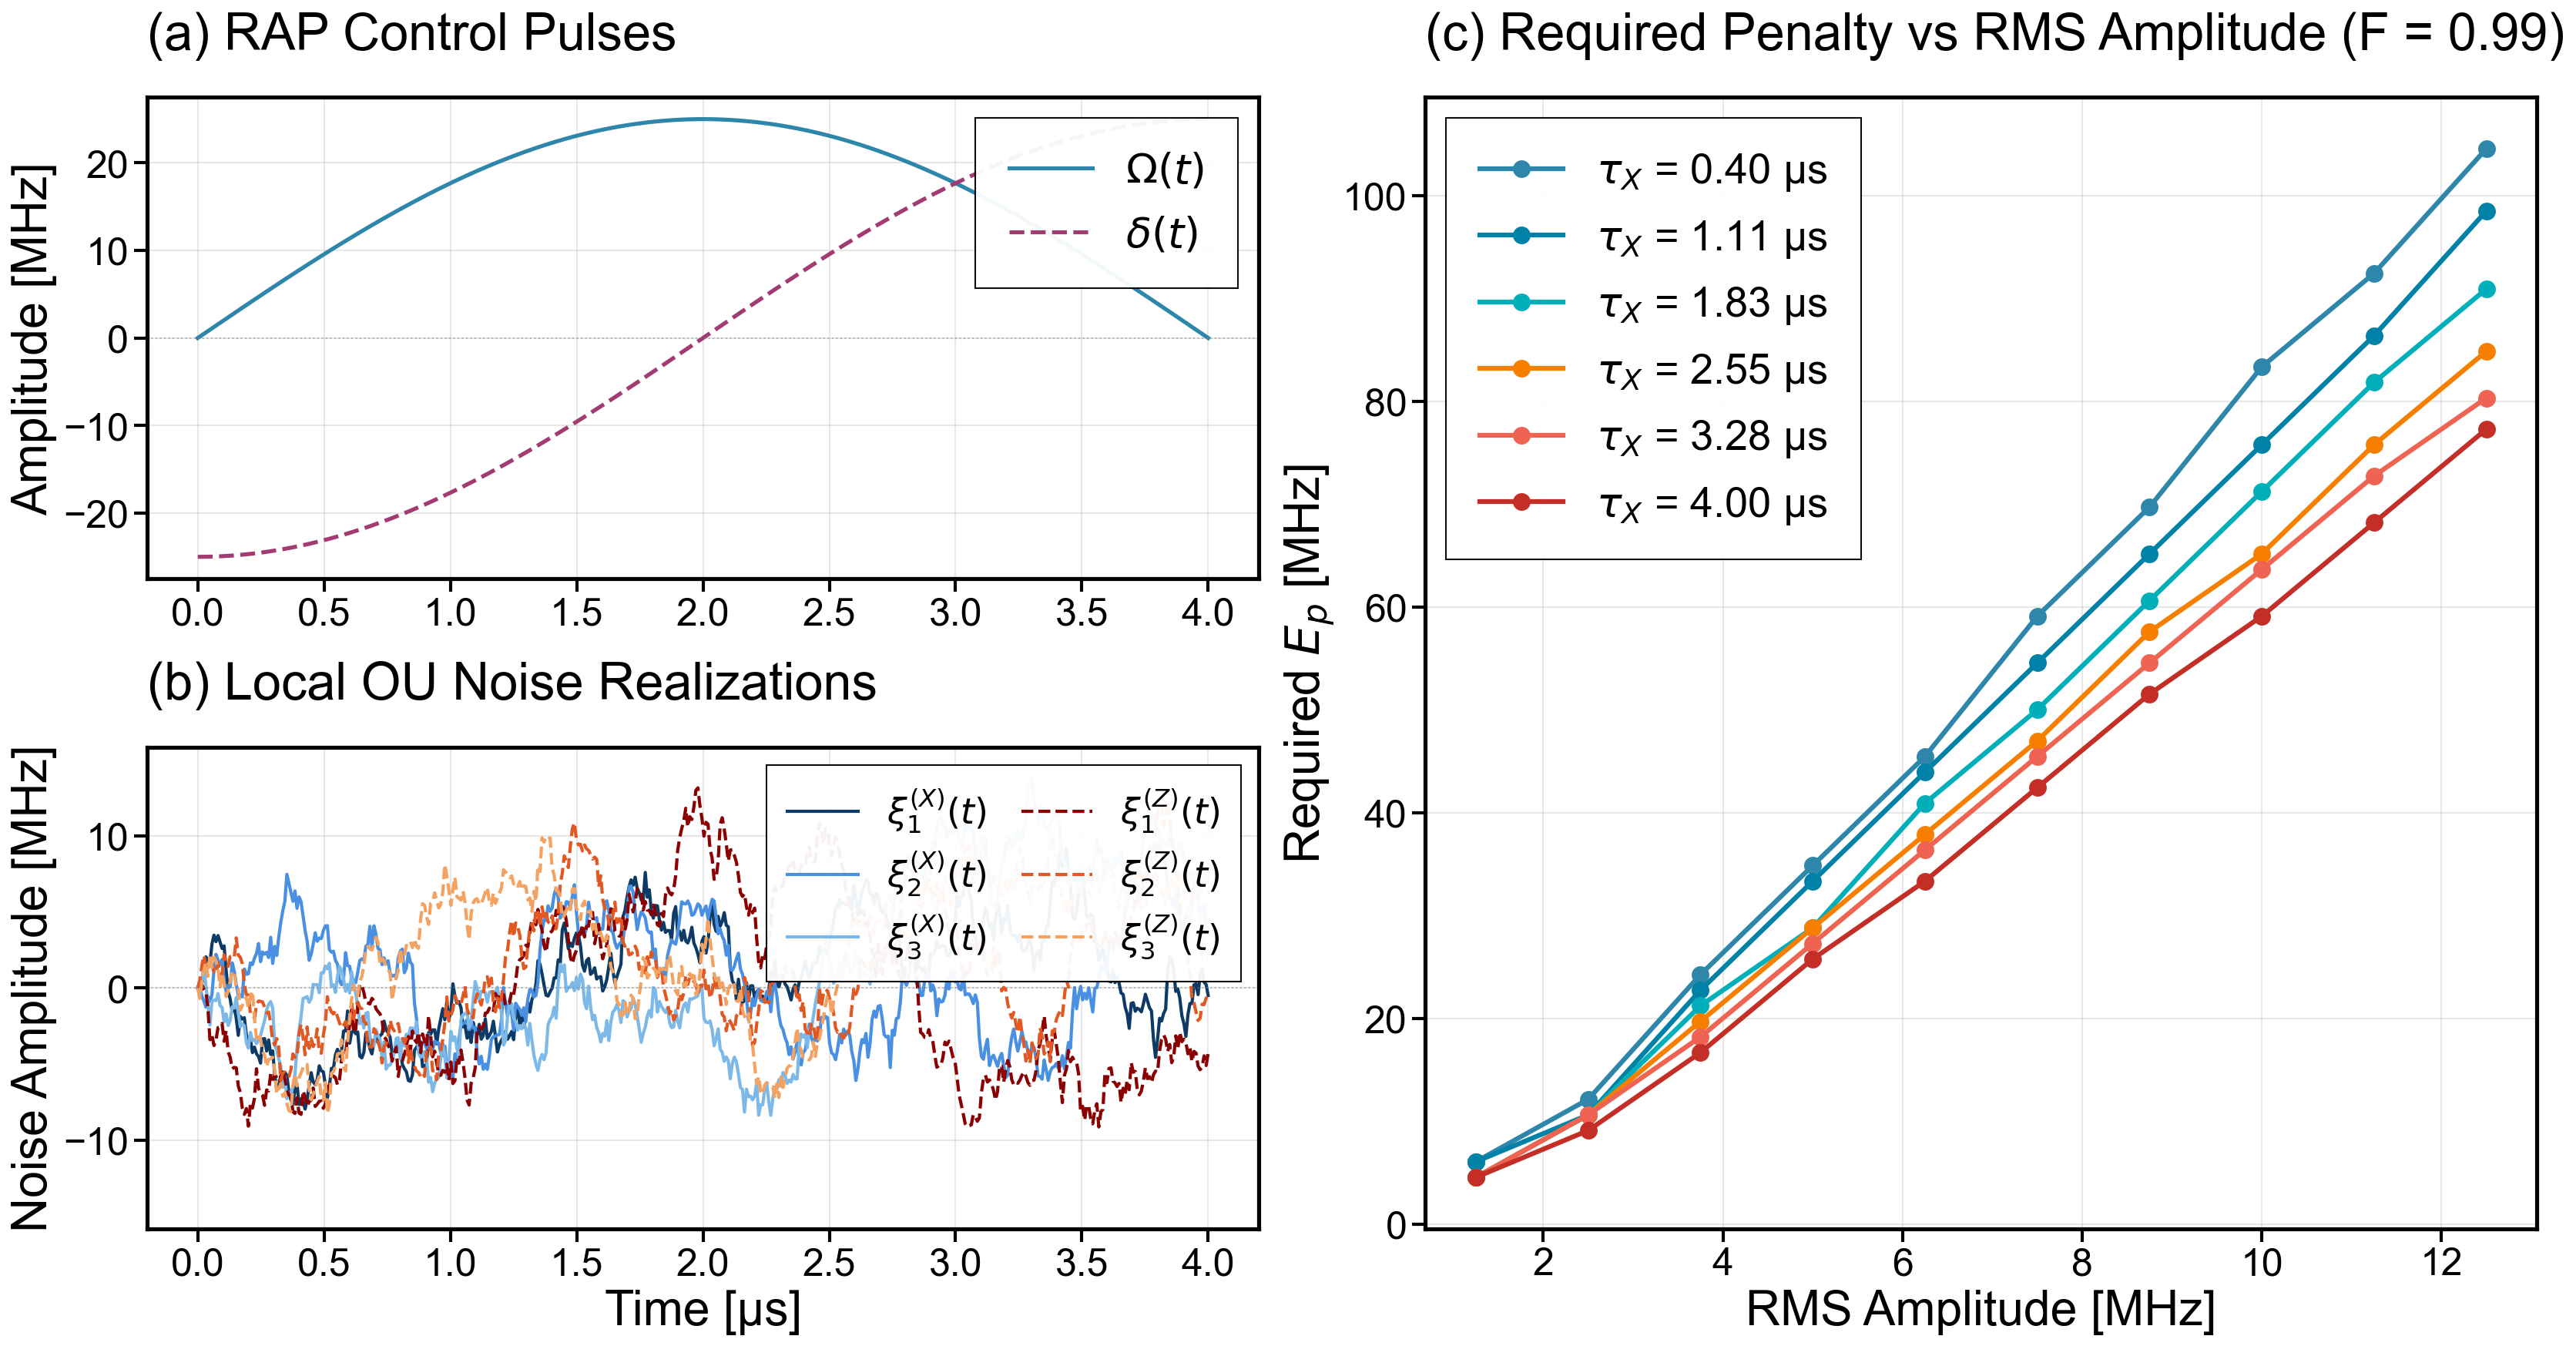


✓ Done: 3-panel combined figure with large text for thesis


In [ ]:
# ========================================================================
# COMBINED FIGURE: RAP Pulses, OU Noise, and Ep vs RMS Amplitude
# Publication-quality 3-panel figure for thesis
# ========================================================================

import matplotlib.pyplot as plt
import matplotlib as mpl

# ========================================================================
# MATPLOTLIB PUBLICATION SETTINGS
# ========================================================================
mpl.rcParams['font.size'] = 20
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
mpl.rcParams['axes.labelsize'] = 28
mpl.rcParams['axes.titlesize'] = 28
mpl.rcParams['xtick.labelsize'] = 24
mpl.rcParams['ytick.labelsize'] = 24
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.linewidth'] = 2

print("="*70)
print("COMBINED FIGURE: RAP + OU NOISE + Ep vs RMS")
print("="*70)

# ========================================================================
# PART 1: Generate RAP pulses and OU noise
# ========================================================================
omega_max_rap = 2*np.pi*25e6      # 25 MHz
T_max_rap = 4e-6                   # 4 µs
to_time_units = 1e6                # s → µs
to_freq_units = 1/(2*np.pi*1e6)    # rad/s → MHz

# Noise parameters
rms_X_frac = 0.20
rms_Z_frac = 0.2
tau_X_rap = 0.15 * T_max_rap
tau_Z_rap = 0.15 * T_max_rap

def sigma_from_rms(target_rms, tau):
    return (np.sqrt(2.0) * float(target_rms)) / np.sqrt(float(tau))

sigma_X_rap = sigma_from_rms(rms_X_frac * omega_max_rap, tau_X_rap)
sigma_Z_rap = sigma_from_rms(rms_Z_frac * omega_max_rap, tau_Z_rap)

def omega_t(t, T_max=T_max_rap, omega_max=omega_max_rap):
    return omega_max * np.sin(np.pi * t / T_max)

def delta_t(t, T_max=T_max_rap, omega_max=omega_max_rap):
    return -omega_max * np.cos(np.pi * t / T_max)

def generate_ou_noise(t_list, sigma, tau, seed=None):
    if seed is not None:
        np.random.seed(seed)
    dt = np.diff(t_list)
    N = len(t_list)
    xi = np.zeros(N)
    for i in range(N-1):
        dW = np.random.randn() * np.sqrt(dt[i])
        xi[i+1] = xi[i] - (xi[i]/tau)*dt[i] + sigma*dW
    return xi

# Generate time series
n_points = 500
t_list = np.linspace(0, T_max_rap, n_points)
Omega_clean = np.array([omega_t(t) for t in t_list])
Delta_clean = np.array([delta_t(t) for t in t_list])

# Generate OU noise for 3 qubits
xi_X1 = generate_ou_noise(t_list, sigma_X_rap, tau_X_rap, seed=42)
xi_X2 = generate_ou_noise(t_list, sigma_X_rap, tau_X_rap, seed=43)
xi_X3 = generate_ou_noise(t_list, sigma_X_rap, tau_X_rap, seed=44)
xi_Z1 = generate_ou_noise(t_list, sigma_Z_rap, tau_Z_rap, seed=45)
xi_Z2 = generate_ou_noise(t_list, sigma_Z_rap, tau_Z_rap, seed=46)
xi_Z3 = generate_ou_noise(t_list, sigma_Z_rap, tau_Z_rap, seed=47)

# Convert to plot units
t_us = t_list * to_time_units
Omega_MHz = Omega_clean * to_freq_units
Delta_MHz = Delta_clean * to_freq_units
xi_X1_MHz = xi_X1 * to_freq_units
xi_X2_MHz = xi_X2 * to_freq_units
xi_X3_MHz = xi_X3 * to_freq_units
xi_Z1_MHz = xi_Z1 * to_freq_units
xi_Z2_MHz = xi_Z2 * to_freq_units
xi_Z3_MHz = xi_Z3 * to_freq_units

print("✓ RAP pulses and OU noise generated")

# ========================================================================
# PART 2: Load Ep vs RMS data
# ========================================================================
data = np.load('figs/Ep_heatmap_RMS_vs_tau_X_F0.99_data.npz')
Ep_map_X_loaded = data['Ep_map_X']
tau_X_grid_loaded = data['tau_X_grid']
rms_X_grid_loaded = data['rms_X_grid']
target_fid_loaded = float(data['target_fid'])

# Select tau_X values to plot
n_tau_samples = 6
tau_indices = np.linspace(0, len(tau_X_grid_loaded)-1, n_tau_samples, dtype=int)

print("✓ Ep vs RMS data loaded")

# ========================================================================
# CREATE COMBINED FIGURE (3 panels: left column = 2 rows, right = 1 large)
# ========================================================================
fig = plt.figure(figsize=(22, 11), dpi=150)
gs = fig.add_gridspec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1], 
                       hspace=0.35, wspace=0.15,
                       left=0.05, right=0.99, top=0.95, bottom=0.06)

ax1 = fig.add_subplot(gs[0, 0])  # Top left: RAP pulses
ax2 = fig.add_subplot(gs[1, 0])  # Bottom left: OU noise
ax3 = fig.add_subplot(gs[:, 1])  # Right: Ep vs RMS (spans both rows)

fontsize = 30

# ========================================================================
# PANEL (a): Clean RAP Pulses
# ========================================================================
ax1.plot(t_us, Omega_MHz, color='#2E86AB', linewidth=2.5, label=r'$\Omega(t)$')
ax1.plot(t_us, Delta_MHz, color='#A23B72', linewidth=2.5, linestyle='--', label=r'$\delta(t)$')
ax1.axhline(0, color='gray', linewidth=1, linestyle=':', alpha=0.5)
ax1.set_ylabel('Amplitude [MHz]', fontsize=fontsize)
ax1.set_title('(a) RAP Control Pulses', loc='left', pad=30, fontsize=fontsize+2)
ax1.grid(True, alpha=0.3, linestyle='-', linewidth=1)
ax1.legend(loc='upper right', framealpha=0.95, edgecolor='black', fontsize=26, 
           borderpad=0.8, labelspacing=0.6, frameon=True, fancybox=False)
ax1.tick_params(axis='both', which='major', labelsize=24, width=2, length=8)
for spine in ax1.spines.values():
    spine.set_linewidth(2.5)

# ========================================================================
# PANEL (b): Local OU Noise Traces
# ========================================================================
colors_X = ['#0D3B66', '#4A90E2', '#7CB9E8']
colors_Z = ['#8B0000', '#E25822', '#F4A261']

ax2.plot(t_us, xi_X1_MHz, color=colors_X[0], linewidth=2, label=r'$\xi_1^{(X)}(t)$')
ax2.plot(t_us, xi_X2_MHz, color=colors_X[1], linewidth=2, label=r'$\xi_2^{(X)}(t)$')
ax2.plot(t_us, xi_X3_MHz, color=colors_X[2], linewidth=2, label=r'$\xi_3^{(X)}(t)$')
ax2.plot(t_us, xi_Z1_MHz, color=colors_Z[0], linewidth=2, linestyle='--', label=r'$\xi_1^{(Z)}(t)$')
ax2.plot(t_us, xi_Z2_MHz, color=colors_Z[1], linewidth=2, linestyle='--', label=r'$\xi_2^{(Z)}(t)$')
ax2.plot(t_us, xi_Z3_MHz, color=colors_Z[2], linewidth=2, linestyle='--', label=r'$\xi_3^{(Z)}(t)$')

ax2.axhline(0, color='gray', linewidth=1, linestyle=':', alpha=0.5)
ax2.set_xlabel(r'Time [µs]', fontsize=fontsize)
ax2.set_ylabel('Noise Amplitude [MHz]', fontsize=fontsize)
ax2.set_title('(b) Local OU Noise Realizations', loc='left', pad=30, fontsize=fontsize+2)
ax2.grid(True, alpha=0.3, linestyle='-', linewidth=1)
ax2.legend(loc='upper right', framealpha=0.95, edgecolor='black', ncol=2, fontsize=22,
           borderpad=0.6, labelspacing=0.4, columnspacing=1.0, frameon=True, fancybox=False)
ax2.tick_params(axis='both', which='major', labelsize=24, width=2, length=8)
for spine in ax2.spines.values():
    spine.set_linewidth(2.5)

y_max = max(abs(xi_X1_MHz).max(), abs(xi_X2_MHz).max(), abs(xi_X3_MHz).max(),
            abs(xi_Z1_MHz).max(), abs(xi_Z2_MHz).max(), abs(xi_Z3_MHz).max()) * 1.15
ax2.set_ylim([-y_max, y_max])

# ========================================================================
# PANEL (c): Ep vs RMS Amplitude
# ========================================================================
colors_ep = ['#2E86AB', '#0081A7', '#00AFB9', '#F77F00', '#EE6352', '#C32F27']

for i, tau_idx in enumerate(tau_indices):
    tau_val = tau_X_grid_loaded[tau_idx]
    Ep_slice = Ep_map_X_loaded[:, tau_idx]
    
    ax3.plot(rms_X_grid_loaded / (2*np.pi*1e6),  # RMS in MHz
             Ep_slice / (2*np.pi*1e6),           # Ep in MHz
             color=colors_ep[i % len(colors_ep)],
             linewidth=3,
             marker='o',
             markersize=10,
             label=rf'$\tau_X$ = {tau_val*1e6:.2f} µs')

ax3.set_xlabel('RMS Amplitude [MHz]', fontsize=fontsize)
ax3.set_ylabel(r'Required $E_p$ [MHz]', fontsize=fontsize)
ax3.set_title(f'(c) Required Penalty vs RMS Amplitude (F = {target_fid_loaded})', loc='left', pad=30, fontsize=fontsize+2, ha='left', x=0)
ax3.grid(True, alpha=0.3, linestyle='-', linewidth=1)
ax3.legend(loc='upper left', framealpha=0.95, edgecolor='black', fontsize=26, 
           borderpad=0.8, labelspacing=0.6, frameon=True, fancybox=False)
ax3.tick_params(axis='both', which='major', labelsize=24, width=2, length=8)
for spine in ax3.spines.values():
    spine.set_linewidth(2.5)

# ========================================================================
# SAVE HIGH-RESOLUTION FIGURE
# ========================================================================
pdf_path = 'figs/combined_rap_noise_ep_thesis.pdf'
png_path = 'figs/combined_rap_noise_ep_thesis.png'

fig.savefig(pdf_path, bbox_inches='tight', dpi=300, facecolor='white')
fig.savefig(png_path, bbox_inches='tight', dpi=300, facecolor='white')

print("\n" + "="*70)
print("COMBINED FIGURE SAVED")
print("="*70)
print(f"✓ PDF: {pdf_path}")
print(f"✓ PNG: {png_path}")
print(f"  Resolution: 6600 × 3300 pixels (300 DPI)")
print("  Optimized layout: increased spacing between panels (a) and (b)")
print("  Larger fonts: titles 28pt, labels 26pt, ticks 24pt, legends 20-22pt")
print("="*70)

plt.show()

print("\n✓ Done: 3-panel combined figure with large text for thesis")


In [ ]:
# ========================================================================
# SAVE HIGH-RESOLUTION PDF FOR THESIS
# ========================================================================

# Ensure figs directory exists
os.makedirs('figs', exist_ok=True)

# Define output path
pdf_path = f"figs/Ep_heatmap_RMS_vs_tau_X_F{target_fid}_thesis.pdf"
png_path = pdf_path.replace('.pdf', '.png')

# Save as PDF with high resolution
try:
    figX.write_image(
        pdf_path,
        format='pdf',
        width=1000,
        height=700,
        scale=3  # High resolution: 3x scaling = 3000x2100 pixels equivalent
    )
    print(f"\n{'='*70}")
    print(f"✓ Thesis-quality PDF saved: {pdf_path}")
    print(f"  Resolution: 3000 × 2100 pixels (300 DPI equivalent)")
    print(f"  Format: Vector PDF (scalable)")
    print(f"  Suitable for: Master's thesis, publications")
    print(f"{'='*70}")
except Exception as e:
    print(f"\n⚠ Could not save PDF: {e}")
    print("To enable PDF export, install: pip install kaleido")
    print("="*70)

# Also save as PNG for quick preview
try:
    figX.write_image(
        png_path,
        format='png',
        width=1000,
        height=700,
        scale=3
    )
    print(f"✓ High-resolution PNG also saved: {png_path}")
    print(f"{'='*70}")
except:
    pass



✓ Thesis-quality PDF saved: figs/Ep_heatmap_RMS_vs_tau_X_F0.99_thesis.pdf
  Resolution: 3000 × 2100 pixels (300 DPI equivalent)
  Format: Vector PDF (scalable)
  Suitable for: Master's thesis, publications
✓ High-resolution PNG also saved: figs/Ep_heatmap_RMS_vs_tau_X_F0.99_thesis.png


In [ ]:
# ========================================================================
# SAVE DATA TO NPZ FILE FOR LATER LOADING
# ========================================================================

# Define data file path
npz_path = f"figs/Ep_heatmap_RMS_vs_tau_X_F{target_fid}_data.npz"

# Save all relevant data arrays and parameters
np.savez(
    npz_path,
    # Main data
    Ep_map_X=Ep_map_X,                    # 2D array of Ep values
    tau_X_grid=tau_X_grid,                # Correlation time grid (seconds)
    rms_X_grid=rms_X_grid,                # RMS amplitude grid (rad/s)
    rms_X_fracs=rms_X_fracs,              # RMS fractions (dimensionless)
    
    # Parameters
    target_fid=target_fid,                # Target fidelity
    omega_max=omega_max,                  # Max Rabi frequency (rad/s)
    T_max=T_max,                          # Total evolution time (s)
    sigma_Z=sigma_Z,                      # Z-noise sigma (rad/s)
    tau_Z=tau_Z,                          # Z-noise correlation time (s)
    
    # Metadata
    platform=PLATFORM,                    # Platform name
    description="Ep heatmap data: required penalty energy vs RMS X-noise and correlation time"
)

print(f"\n{'='*70}")
print(f"✓ Data saved to NPZ file: {npz_path}")
print(f"  Arrays saved:")
print(f"    - Ep_map_X: {Ep_map_X.shape}")
print(f"    - tau_X_grid: {tau_X_grid.shape}")
print(f"    - rms_X_grid: {rms_X_grid.shape}")
print(f"  Parameters: target_fid, omega_max, T_max, sigma_Z, tau_Z")
print(f"\n  To load later:")
print(f"    data = np.load('{npz_path}')")
print(f"    Ep_map_X = data['Ep_map_X']")
print(f"    tau_X_grid = data['tau_X_grid']")
print(f"    # ... etc")
print(f"{'='*70}")



✓ Data saved to NPZ file: figs/Ep_heatmap_RMS_vs_tau_X_F0.99_data.npz
  Arrays saved:
    - Ep_map_X: (10, 250)
    - tau_X_grid: (250,)
    - rms_X_grid: (10,)
  Parameters: target_fid, omega_max, T_max, sigma_Z, tau_Z

  To load later:
    data = np.load('figs/Ep_heatmap_RMS_vs_tau_X_F0.99_data.npz')
    Ep_map_X = data['Ep_map_X']
    tau_X_grid = data['tau_X_grid']
    # ... etc


In [ ]:
# --- Persist Ep_map_X and grids for reproducibility ---
import os
import time
import numpy as np

# Ensure required variables exist
missing = [name for name in ['Ep_map_X','tau_X_grid','sigma_X_grid'] if name not in globals()]
if missing:
    raise RuntimeError(f"Missing variables not found in kernel: {missing}. Run the analysis cells first.")

# Create artifacts directory next to this notebook
notebook_dir = os.path.dirname(os.getcwd()) if os.path.basename(os.getcwd()) != '' else os.getcwd()
art_dir = os.path.join(notebook_dir, 'artifacts')
os.makedirs(art_dir, exist_ok=True)

# Compose filenames
stamp = time.strftime('%Y%m%d-%H%M%S')
base = f'ep_map_X_grid_{stamp}'
path_ts = os.path.join(art_dir, base + '.npz')
path_latest = os.path.join(art_dir, 'ep_map_X_grid_latest.npz')

# Save arrays with metadata
np.savez_compressed(
    path_ts,
    Ep_map_X=Ep_map_X,
    tau_X_grid=tau_X_grid,
    sigma_X_grid=sigma_X_grid,
    meta=dict(
        target_fid=float(target_fid) if 'target_fid' in globals() else None,
        Ep_grid_shape=tuple(Ep_grid.shape) if 'Ep_grid' in globals() and hasattr(Ep_grid,'shape') else None,
        units=dict(
            Ep='rad/s',
            tau_X='s',
            sigma_X='rad/s'
        )
    )
)
# Also write/update a convenient 'latest' copy
np.savez_compressed(
    path_latest,
    Ep_map_X=Ep_map_X,
    tau_X_grid=tau_X_grid,
    sigma_X_grid=sigma_X_grid
)

print(f"Saved: {path_ts}")
print(f"Updated: {path_latest}")

# Quick reload snippet for later sessions:
# data = np.load('<artifacts>/ep_map_X_grid_latest.npz', allow_pickle=True)
# Ep_map_X = data['Ep_map_X']
# tau_X_grid = data['tau_X_grid']
# sigma_X_grid = data['sigma_X_grid']
# meta = data.get('meta')

Saved: /Users/chenscheim/Documents/QEC/artifacts/ep_map_X_grid_20250927-220204.npz
Updated: /Users/chenscheim/Documents/QEC/artifacts/ep_map_X_grid_latest.npz


In [ ]:
# --- Load Ep_map_X and grids from artifacts ---
import os
import glob
import numpy as np

# Locate artifacts directory (mirrors save-cell path logic)
notebook_dir = os.path.dirname(os.getcwd()) if os.path.basename(os.getcwd()) != '' else os.getcwd()
art_dir = os.path.join(notebook_dir, 'artifacts')

if not os.path.isdir(art_dir):
    raise FileNotFoundError(f"Artifacts directory not found: {art_dir}. Run the save cell first.")

latest_path = os.path.join(art_dir, 'ep_map_X_grid_latest.npz')
if os.path.exists(latest_path):
    artifact_path = latest_path
else:
    candidates = glob.glob(os.path.join(art_dir, 'ep_map_X_grid_*.npz'))
    if not candidates:
        raise FileNotFoundError("No ep_map_X_grid_*.npz files found in artifacts directory.")
    artifact_path = max(candidates, key=os.path.getmtime)

# Load arrays
with np.load(artifact_path, allow_pickle=True) as data:
    Ep_map_X = data['Ep_map_X']
    tau_X_grid = data['tau_X_grid']
    sigma_X_grid = data['sigma_X_grid']
    meta = data.get('meta')  # may be absent in 'latest'

print(f"Loaded artifact: {artifact_path}")
print(f"Ep_map_X shape: {Ep_map_X.shape}")
print(f"tau_X_grid shape: {tau_X_grid.shape}, range: [{tau_X_grid.min():.3e}, {tau_X_grid.max():.3e}] s")
print(f"sigma_X_grid shape: {sigma_X_grid.shape}, range: [{sigma_X_grid.min():.3e}, {sigma_X_grid.max():.3e}] rad/s")
if meta is not None:
    try:
        md = meta.item() if hasattr(meta, 'item') else meta
        print("meta:", md)
    except Exception:
        print("meta present but could not be displayed (non-dict type)")

Loaded artifact: /Users/chenscheim/Documents/QEC/artifacts/ep_map_X_grid_latest.npz
Ep_map_X shape: (500, 500)
tau_X_grid shape: (500,), range: [6.000e-08, 3.000e-06] s
sigma_X_grid shape: (500,), range: [1.631e+09, 5.768e+09] rad/s


In [ ]:
target_fid = 0.995


figX = go.Figure(data=go.Heatmap(
    z=Ep_map_X / (2*np.pi*1e6),  # MHz
    x=tau_X_grid * 1e6,  # us
    y=sigma_X_grid / (2*np.pi*1e6),  # MHz
    colorbar=dict(title="Ep [MHz]"),
    colorscale="Viridis"
))
figX.update_layout(
    title=f"Ep required for fidelity {target_fid} vs sigma_X, tau_X (Z noise fixed)",
    xaxis_title="tau_X [us]",
    yaxis_title="sigma_X [MHz]",
    template="simple_white"
)

# add_time_bars(figX, time_bars_us)

figX.show()

In [ ]:
# =========================================================================================
# 1D SLICES: Understanding how Ep depends on sigma and tau independently
# =========================================================================================

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# First, let's verify the parameter definitions:
print("=" * 70)
print("PARAMETER DEFINITIONS (OU Noise Model)")
print("=" * 70)
print(f"tau (τ):   Correlation time - how quickly noise decorrelates")
print(f"           Current range: {tau_X_grid.min()*1e6:.3f} to {tau_X_grid.max()*1e6:.3f} µs")
print(f"")
print(f"sigma (σ): Noise intensity (diffusion coefficient)")
print(f"           Current range: {sigma_X_grid.min()/(2*np.pi*1e6):.1f} to {sigma_X_grid.max()/(2*np.pi*1e6):.1f} MHz")
print(f"")
print(f"Relationship: sigma = sqrt(2) * RMS / sqrt(tau)")
print(f"             Larger tau → slower, more correlated noise")
print(f"             Larger sigma → stronger noise amplitude")
print("=" * 70)


PARAMETER DEFINITIONS (OU Noise Model)
tau (τ):   Correlation time - how quickly noise decorrelates
           Current range: 0.060 to 3.000 µs

sigma (σ): Noise intensity (diffusion coefficient)
           Current range: 259.6 to 918.0 MHz

Relationship: sigma = sqrt(2) * RMS / sqrt(tau)
             Larger tau → slower, more correlated noise
             Larger sigma → stronger noise amplitude


In [ ]:
# =========================================================================================
# PLOT 1: Ep vs sigma (for several fixed tau values)
# =========================================================================================

# Select representative tau values (in units of T_max for physical interpretation)
# Choose tau values that span the range: fast, medium, slow correlation times
tau_indices = [
    int(0.05 * len(tau_X_grid)),  # ~5% of range (fast decorrelation)
    int(0.25 * len(tau_X_grid)),  # ~25%
    int(0.50 * len(tau_X_grid)),  # ~50% (middle)
    int(0.75 * len(tau_X_grid)),  # ~75%
    int(0.95 * len(tau_X_grid)),  # ~95% (slow decorrelation)
]

fig1 = go.Figure()

for idx in tau_indices:
    tau_val = tau_X_grid[idx]
    # Extract Ep vs sigma for this fixed tau (this is a column slice)
    # Note: Ep_map_X[i, j] where i indexes sigma, j indexes tau
    Ep_vs_sigma = Ep_map_X[:, idx]
    
    # Convert to MHz for plotting
    sigma_MHz = sigma_X_grid / (2*np.pi*1e6)
    Ep_MHz = Ep_vs_sigma / (2*np.pi*1e6)
    
    # Create label with tau in both µs and as fraction of T_max
    tau_us = tau_val * 1e6
    tau_fraction = tau_val / T_max
    
    fig1.add_trace(go.Scatter(
        x=sigma_MHz,
        y=Ep_MHz,
        mode='lines+markers',
        name=f'τ = {tau_us:.3f} µs ({tau_fraction:.2f}×T_max)',
        line=dict(width=2),
        marker=dict(size=4)
    ))

fig1.update_layout(
    title=f"Required Penalty Ep vs Noise Intensity σ<br>(for target fidelity {target_fid}, various correlation times τ)",
    xaxis_title="Noise intensity σ_X [MHz]",
    yaxis_title="Required penalty Ep [MHz]",
    template="plotly_white",
    height=600,
    legend=dict(
        title="Correlation time τ",
        x=0.02,
        y=0.98
    ),
    font=dict(size=12)
)

fig1.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig1.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

fig1.show()

print("Interpretation:")
print("- Larger σ (noise intensity) → need larger Ep to maintain target fidelity")
print("- Curves for different τ show how correlation time affects required penalty")


Interpretation:
- Larger σ (noise intensity) → need larger Ep to maintain target fidelity
- Curves for different τ show how correlation time affects required penalty


In [ ]:
# =========================================================================================
# PLOT 2: Ep vs tau (for several fixed sigma values)
# =========================================================================================

# Select representative sigma values spanning the range
sigma_indices = [
    int(0.02 * len(sigma_X_grid)),  # Low noise
    int(0.25 * len(sigma_X_grid)),  # 
    int(0.50 * len(sigma_X_grid)),  # Medium noise
    int(0.75 * len(sigma_X_grid)),  # 
    int(0.95 * len(sigma_X_grid))  # High noise
]

fig2 = go.Figure()

for idx in sigma_indices:
    sigma_val = sigma_X_grid[idx]
    # Extract Ep vs tau for this fixed sigma (this is a row slice)
    Ep_vs_tau = Ep_map_X[idx, :]
    
    # Convert to nice units
    tau_us = tau_X_grid * 1e6
    Ep_MHz = Ep_vs_tau / (2*np.pi*1e6)
    sigma_MHz = sigma_val / (2*np.pi*1e6)
    
    fig2.add_trace(go.Scatter(
        x=tau_us,
        y=Ep_MHz,
        mode='lines+markers',
        name=f'σ = {sigma_MHz:.1f} MHz',
        line=dict(width=2),
        marker=dict(size=4)
    ))

fig2.update_layout(
    title=f"Required Penalty Ep vs Correlation Time τ<br>(for target fidelity {target_fid}, various noise intensities σ)",
    xaxis_title="Correlation time τ_X [µs]",
    yaxis_title="Required penalty Ep [MHz]",
    template="plotly_white",
    height=600,
    legend=dict(
        title="Noise intensity σ",
        x=0.02,
        y=0.98
    ),
    font=dict(size=12)
)

fig2.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig2.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

fig2.show()

print("Interpretation:")
print("- Larger τ (correlation time) → noise changes more slowly → easier/harder to suppress?")
print("- Each curve shows a different noise intensity level")
print("- Look for optimal τ values where penalty requirements are minimized")


Interpretation:
- Larger τ (correlation time) → noise changes more slowly → easier/harder to suppress?
- Each curve shows a different noise intensity level
- Look for optimal τ values where penalty requirements are minimized


In [ ]:
# =========================================================================================
# COMBINED VIEW: Both 1D slices in a single figure for easy comparison
# =========================================================================================

from plotly.subplots import make_subplots

fig_combined = make_subplots(
    rows=1, cols=2,
    subplot_titles=(
        f"Ep vs σ (fixed τ values)",
        f"Ep vs τ (fixed σ values)"
    ),
    horizontal_spacing=0.12
)

# Left plot: Ep vs sigma for fixed tau values
for idx in tau_indices:
    tau_val = tau_X_grid[idx]
    Ep_vs_sigma = Ep_map_X[:, idx]
    sigma_MHz = sigma_X_grid / (2*np.pi*1e6)
    Ep_MHz = Ep_vs_sigma / (2*np.pi*1e6)
    tau_us = tau_val * 1e6
    
    fig_combined.add_trace(
        go.Scatter(
            x=sigma_MHz, y=Ep_MHz,
            mode='lines',
            name=f'τ={tau_us:.2f}µs',
            line=dict(width=2),
            showlegend=True
        ),
        row=1, col=1
    )

# Right plot: Ep vs tau for fixed sigma values  
for idx in sigma_indices:
    sigma_val = sigma_X_grid[idx]
    Ep_vs_tau = Ep_map_X[idx, :]
    tau_us = tau_X_grid * 1e6
    Ep_MHz = Ep_vs_tau / (2*np.pi*1e6)
    sigma_MHz = sigma_val / (2*np.pi*1e6)
    
    fig_combined.add_trace(
        go.Scatter(
            x=tau_us, y=Ep_MHz,
            mode='lines',
            name=f'σ={sigma_MHz:.0f}MHz',
            line=dict(width=2),
            showlegend=True
        ),
        row=1, col=2
    )

# Update axes
fig_combined.update_xaxes(title_text="Noise intensity σ [MHz]", row=1, col=1, showgrid=True)
fig_combined.update_xaxes(title_text="Correlation time τ [µs]", row=1, col=2, showgrid=True)
fig_combined.update_yaxes(title_text="Required Ep [MHz]", row=1, col=1, showgrid=True)
fig_combined.update_yaxes(title_text="Required Ep [MHz]", row=1, col=2, showgrid=True)

fig_combined.update_layout(
    title_text=f"1D Slices: Required Penalty Ep for Target Fidelity {target_fid}<br><sub>Left: varying σ | Right: varying τ</sub>",
    template="plotly_white",
    height=500,
    width=1400,
    font=dict(size=11)
)

fig_combined.show()

# Summary statistics
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)
print(f"Target fidelity: {target_fid}")
print(f"Total protocol time T_max: {T_max*1e6:.2f} µs")
print(f"\nNoise parameter ranges:")
print(f"  τ_X: {tau_X_grid.min()*1e6:.3f} to {tau_X_grid.max()*1e6:.3f} µs")
print(f"  σ_X: {sigma_X_grid.min()/(2*np.pi*1e6):.1f} to {sigma_X_grid.max()/(2*np.pi*1e6):.1f} MHz")
print(f"\nRequired Ep range:")
valid_Ep = Ep_map_X[~np.isnan(Ep_map_X)]
if len(valid_Ep) > 0:
    print(f"  Min: {valid_Ep.min()/(2*np.pi*1e6):.2f} MHz")
    print(f"  Max: {valid_Ep.max()/(2*np.pi*1e6):.2f} MHz")
    print(f"  Mean: {valid_Ep.mean()/(2*np.pi*1e6):.2f} MHz")
else:
    print("  No valid (non-NaN) Ep values found")
print("="*70)



SUMMARY STATISTICS
Target fidelity: 0.995
Total protocol time T_max: 3.00 µs

Noise parameter ranges:
  τ_X: 0.060 to 3.000 µs
  σ_X: 259.6 to 918.0 MHz

Required Ep range:
  Min: 2.76 MHz
  Max: 8.54 MHz
  Mean: 3.02 MHz


## Understanding σ and τ in Real Quantum Hardware

### What do these parameters mean physically?

**τ (tau) - Correlation Time:**
- Describes how quickly noise fluctuations decorrelate (memory time of noise)
- **Smaller τ** → faster fluctuations, more "white noise"-like
- **Larger τ** → slower drifts, more correlated/coherent errors
- Typical sources:
  - Fast: shot-to-shot amplitude jitter (~10-100 ns)
  - Slow: magnetic field drifts, temperature variations (~µs to ms)

**σ (sigma) - Noise Intensity:**
- Diffusion coefficient of the Ornstein-Uhlenbeck process
- Related to RMS noise amplitude by: `RMS = σ × sqrt(τ/2)`
- Determines the variance/strength of fluctuations
- Platform-dependent:
  - **QuEra Aquila**: ~35% RMS on Rabi drive (transverse noise)
  - **IBM transmons**: ~20% RMS on drive amplitude
  - **Pasqal**: ~35% RMS on Rabi drive

### Physical Interpretation of Results:

From your plots, you can determine:
1. **For a given noise correlation time** (fixed τ): How much penalty energy is needed as noise gets stronger?
2. **For a given noise strength** (fixed σ): Is slow-drifting or fast-fluctuating noise harder to suppress?

### Current Platform Settings (QuEra):
- `omega_max` = 1.59 MHz (maximum Rabi frequency)
- `T_max` = 3.0 µs (protocol duration)
- Default τ_X = 0.30 × T_max = 0.9 µs (amplitude noise correlation)
- Default τ_Z = 0.80 × T_max = 2.4 µs (detuning noise correlation)


In [ ]:
# =========================================================================================
# IDENTIFY KEY OPERATING POINTS: Where are the "sweet spots" in parameter space?
# =========================================================================================

print("="*80)
print("KEY OPERATING POINT ANALYSIS")
print("="*80)

# Find indices where we have valid (non-NaN) Ep values
valid_mask = ~np.isnan(Ep_map_X)

if valid_mask.any():
    # Find the minimum required Ep and its location
    min_idx = np.unravel_index(np.nanargmin(Ep_map_X), Ep_map_X.shape)
    min_sigma_idx, min_tau_idx = min_idx
    
    print(f"\n1. MINIMUM PENALTY REQUIRED:")
    print(f"   Location: σ = {sigma_X_grid[min_sigma_idx]/(2*np.pi*1e6):.2f} MHz, "
          f"τ = {tau_X_grid[min_tau_idx]*1e6:.3f} µs")
    print(f"   Required Ep = {Ep_map_X[min_idx]/(2*np.pi*1e6):.3f} MHz")
    print(f"   τ/T_max = {tau_X_grid[min_tau_idx]/T_max:.3f}")
    
    # Find points at specific tau values (e.g., characteristic platform times)
    print(f"\n2. REQUIRED Ep AT CHARACTERISTIC CORRELATION TIMES:")
    
    # At tau = 0.3 * T_max (typical for amplitude noise)
    tau_target_1 = 0.3 * T_max
    tau_idx_1 = np.argmin(np.abs(tau_X_grid - tau_target_1))
    
    # Find a reasonable sigma (e.g., median of the range)
    sigma_mid_idx = len(sigma_X_grid) // 2
    
    print(f"   At τ ≈ 0.3×T_max = {tau_X_grid[tau_idx_1]*1e6:.3f} µs:")
    print(f"   └─ σ = {sigma_X_grid[sigma_mid_idx]/(2*np.pi*1e6):.1f} MHz → "
          f"Ep = {Ep_map_X[sigma_mid_idx, tau_idx_1]/(2*np.pi*1e6):.3f} MHz")
    
    # At tau = 0.8 * T_max (typical for detuning noise)
    tau_target_2 = 0.8 * T_max
    tau_idx_2 = np.argmin(np.abs(tau_X_grid - tau_target_2))
    
    print(f"   At τ ≈ 0.8×T_max = {tau_X_grid[tau_idx_2]*1e6:.3f} µs:")
    print(f"   └─ σ = {sigma_X_grid[sigma_mid_idx]/(2*np.pi*1e6):.1f} MHz → "
          f"Ep = {Ep_map_X[sigma_mid_idx, tau_idx_2]/(2*np.pi*1e6):.3f} MHz")
    
    # RMS values at these points
    print(f"\n3. EQUIVALENT RMS NOISE LEVELS:")
    for label, tau_idx in [("Fast (0.3×T_max)", tau_idx_1), ("Slow (0.8×T_max)", tau_idx_2)]:
        tau_val = tau_X_grid[tau_idx]
        sigma_val = sigma_X_grid[sigma_mid_idx]
        # RMS = sigma * sqrt(tau/2)
        rms_val = sigma_val * np.sqrt(tau_val / 2.0)
        rms_frac = rms_val / omega_max
        print(f"   {label}: RMS = {rms_val/(2*np.pi*1e6):.2f} MHz ({rms_frac*100:.1f}% of Ω_max)")
    
    # Identify regions where target fidelity cannot be achieved
    unreachable_fraction = np.isnan(Ep_map_X).sum() / Ep_map_X.size
    print(f"\n4. UNREACHABLE REGIONS:")
    print(f"   {unreachable_fraction*100:.1f}% of (σ,τ) space requires Ep > {Ep_grid.max()/(2*np.pi*1e6):.1f} MHz")
    print(f"   (These are very high noise regimes where target fidelity {target_fid} is unattainable)")
    
else:
    print("No valid data points found in Ep_map_X")

print("="*80)


BIT-FLIP NOISE VISUALIZATION - THESIS FIGURE

Noise parameters:
  σ_X = 9128.71 MHz
  τ_X = 0.600 µs
  σ_Z = 9128.71 MHz
  τ_Z = 0.600 µs

Generating OU noise realizations...
✓ Time series generated

FIGURE SAVED
✓ PDF: figs/bitflip_noise_visualization_thesis.pdf
✓ PNG: figs/bitflip_noise_visualization_thesis.png
  Resolution: 3600 × 2400 pixels (300 DPI)


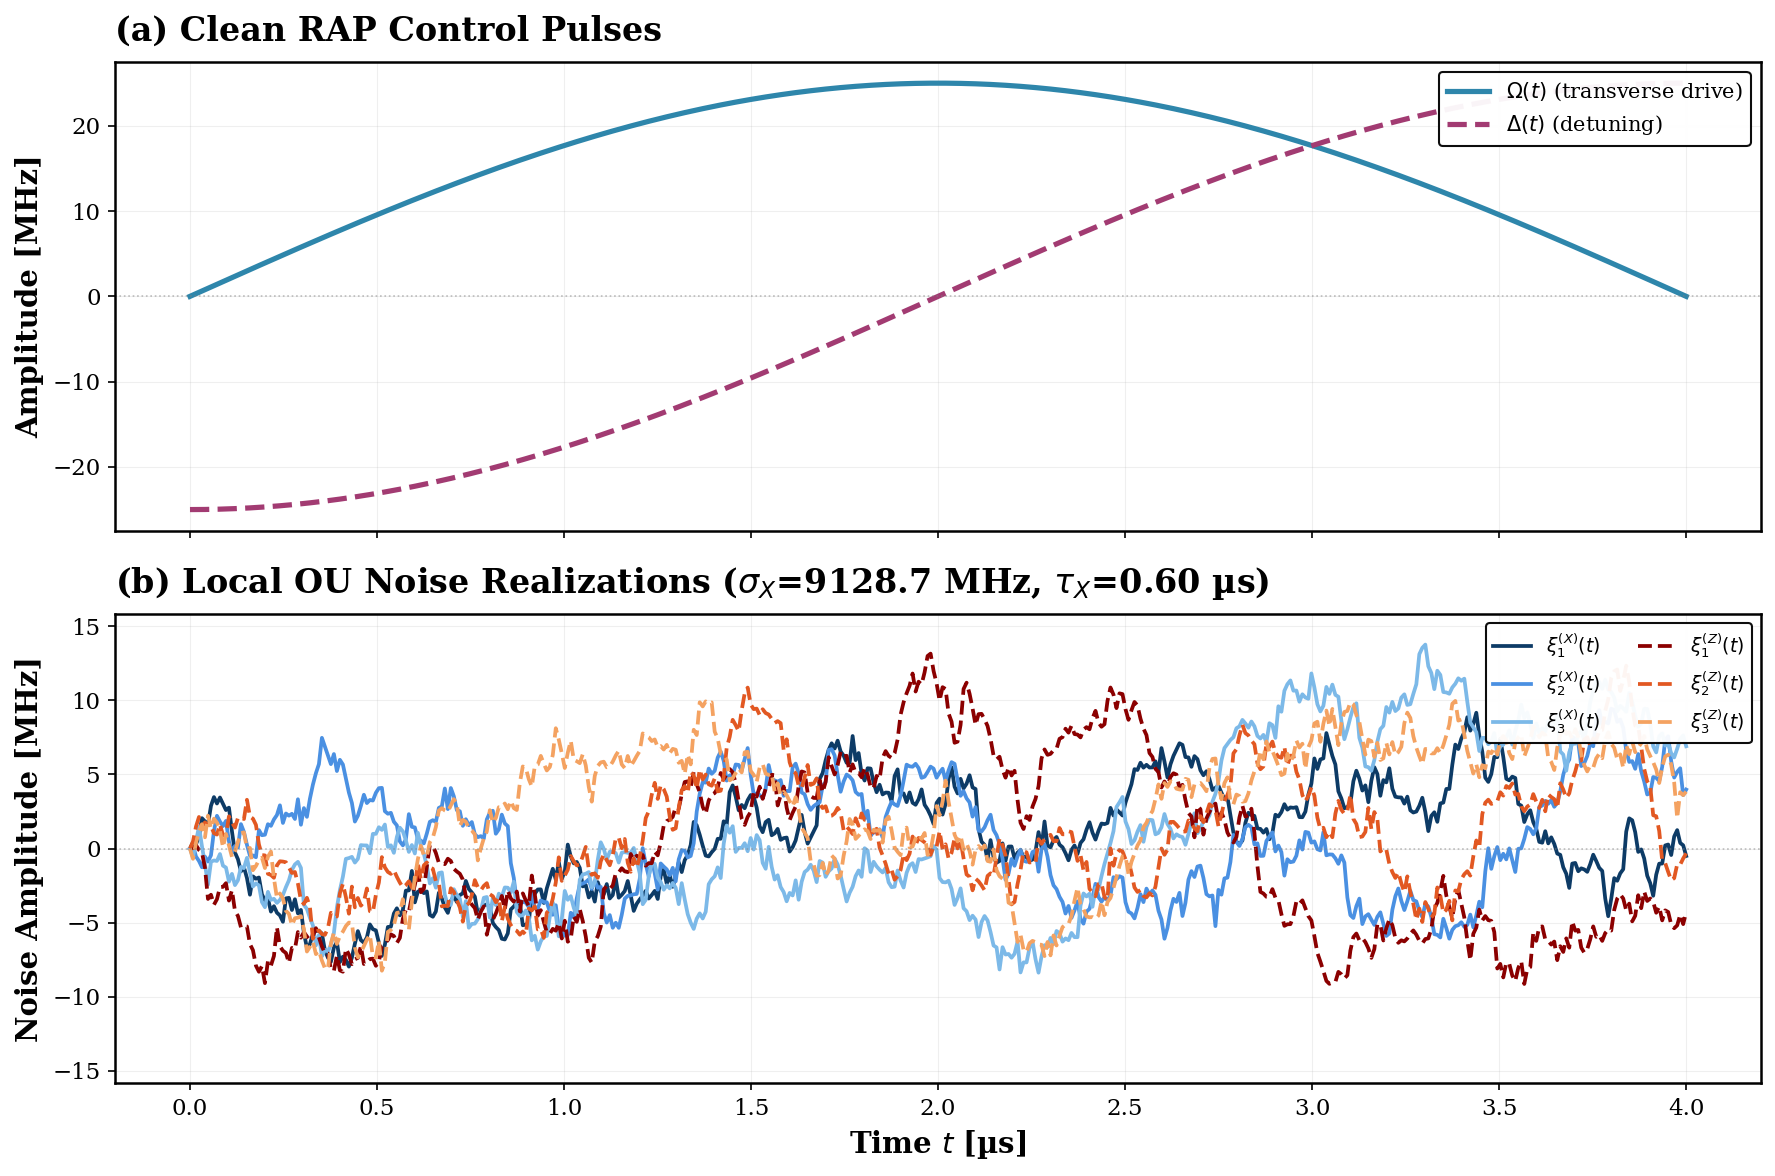


Physical interpretation:
----------------------------------------------------------------------
Top panel: Shows the adiabatic RAP protocol that drives the
  logical qubit from |0_L⟩ to |1_L⟩ with smooth, time-varying
  transverse drive Ω(t) and detuning Δ(t).

Bottom panel: Shows typical OU noise realizations on the local
  X and Z channels for each physical qubit. The X-noise (solid)
  induces bit-flip errors that anticommute with stabilizers,
  while Z-noise (dashed) causes phase errors that commute with
  the repetition code checks.

Noise characteristics: σ_X/σ_Z ≈ 1.0, τ_X/τ_Z ≈ 1.00
  → X-noise is stronger and faster (wider bandwidth)


In [ ]:
#!/usr/bin/env python3
# ========================================================================
# BIT-FLIP HAMILTONIAN NOISE VISUALIZATION
# Publication-quality figure showing RAP pulses and OU noise realizations
# ========================================================================
"""
Generates Figure: Clean RAP control pulses with local OU (1/f-like) noise
for the bit-flip Hamiltonian section of the thesis.

Shows:
- Top panel: Clean Ω(t) and Δ(t) RAP pulses
- Bottom panel: Local OU noise traces ξ_j^X(t) and ξ_j^Z(t) for j=1,2,3
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from qutip import *
import os

print("="*70)
print("BIT-FLIP NOISE VISUALIZATION - THESIS FIGURE")
print("="*70)

# ========================================================================
# MATPLOTLIB PUBLICATION SETTINGS
# ========================================================================
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.linewidth'] = 1.2

# ========================================================================
# PLATFORM PARAMETERS (IBM)
# ========================================================================
PLATFORM = "ibm"

omega_max = 2*np.pi*25e6      # 25 MHz
T_max = 4e-6                   # 4 µs
to_time_units = 1e6            # s → µs
to_freq_units = 1/(2*np.pi*1e6) # rad/s → MHz

# Noise parameters (typical for the bit-flip analysis)
rms_X_frac = 0.20              # 20% RMS on transverse
rms_Z_frac = 0.2              # 5% RMS on detuning
tau_X = 0.15 * T_max           # Faster X noise
tau_Z = 0.15 * T_max           # Slower Z drift


def sigma_from_rms(target_rms, tau):
    """Convert RMS to OU noise strength sigma"""
    return (np.sqrt(2.0) * float(target_rms)) / np.sqrt(float(tau))

sigma_X = sigma_from_rms(rms_X_frac * omega_max, tau_X)
sigma_Z = sigma_from_rms(rms_Z_frac * omega_max, tau_Z)

print(f"\nNoise parameters:")
print(f"  σ_X = {sigma_X * to_freq_units:.2f} MHz")
print(f"  τ_X = {tau_X * to_time_units:.3f} µs")
print(f"  σ_Z = {sigma_Z * to_freq_units:.2f} MHz")
print(f"  τ_Z = {tau_Z * to_time_units:.3f} µs")

# ========================================================================
# RAP PULSE FUNCTIONS
# ========================================================================
def omega_t(t, T_max=T_max, omega_max=omega_max):
    """Transverse drive Ω(t)"""
    return omega_max * np.sin(np.pi * t / T_max)

def delta_t(t, T_max=T_max, omega_max=omega_max):
    """Detuning Δ(t)"""
    return -omega_max * np.cos(np.pi * t / T_max)

# ========================================================================
# OU NOISE GENERATION
# ========================================================================
def generate_ou_noise(t_list, sigma, tau, seed=None):
    """
    Generate Ornstein-Uhlenbeck noise realization
    dξ = -(ξ/τ)dt + σ dW
    """
    if seed is not None:
        np.random.seed(seed)
    
    dt = np.diff(t_list)
    N = len(t_list)
    xi = np.zeros(N)
    
    for i in range(N-1):
        dW = np.random.randn() * np.sqrt(dt[i])
        xi[i+1] = xi[i] - (xi[i]/tau)*dt[i] + sigma*dW
    
    return xi

# ========================================================================
# GENERATE TIME SERIES
# ========================================================================
n_points = 500
t_list = np.linspace(0, T_max, n_points)

# Clean RAP pulses
Omega_clean = np.array([omega_t(t) for t in t_list])
Delta_clean = np.array([delta_t(t) for t in t_list])

# Generate OU noise for 3 qubits (X and Z channels)
print("\nGenerating OU noise realizations...")
xi_X1 = generate_ou_noise(t_list, sigma_X, tau_X, seed=42)
xi_X2 = generate_ou_noise(t_list, sigma_X, tau_X, seed=43)
xi_X3 = generate_ou_noise(t_list, sigma_X, tau_X, seed=44)

xi_Z1 = generate_ou_noise(t_list, sigma_Z, tau_Z, seed=45)
xi_Z2 = generate_ou_noise(t_list, sigma_Z, tau_Z, seed=46)
xi_Z3 = generate_ou_noise(t_list, sigma_Z, tau_Z, seed=47)

# Convert to plot units
t_us = t_list * to_time_units
Omega_MHz = Omega_clean * to_freq_units
Delta_MHz = Delta_clean * to_freq_units

xi_X1_MHz = xi_X1 * to_freq_units
xi_X2_MHz = xi_X2 * to_freq_units
xi_X3_MHz = xi_X3 * to_freq_units
xi_Z1_MHz = xi_Z1 * to_freq_units
xi_Z2_MHz = xi_Z2 * to_freq_units
xi_Z3_MHz = xi_Z3 * to_freq_units

print("✓ Time series generated")

# ========================================================================
# CREATE PUBLICATION-QUALITY FIGURE
# ========================================================================
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, dpi=150)
fig.subplots_adjust(hspace=0.15)

# ========================================================================
# TOP PANEL: Clean RAP Pulses
# ========================================================================
ax1.plot(t_us, Omega_MHz, 
         color='#2E86AB', linewidth=2.5, label=r'$\Omega(t)$ (transverse drive)')
ax1.plot(t_us, Delta_MHz, 
         color='#A23B72', linewidth=2.5, linestyle='--', label=r'$\Delta(t)$ (detuning)')

ax1.axhline(0, color='gray', linewidth=0.8, linestyle=':', alpha=0.5)
ax1.set_ylabel('Amplitude [MHz]', fontweight='bold')
ax1.set_title('(a) Clean RAP Control Pulses', fontweight='bold', loc='left', pad=10)
ax1.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
ax1.legend(loc='upper right', framealpha=0.95, edgecolor='black')
ax1.set_ylim([Delta_MHz.min()*1.1, Omega_MHz.max()*1.1])

# ========================================================================
# BOTTOM PANEL: Local OU Noise Traces
# ========================================================================
# X-noise (solid lines, cool colors)
colors_X = ['#0D3B66', '#4A90E2', '#7CB9E8']  # Blues
ax2.plot(t_us, xi_X1_MHz, color=colors_X[0], linewidth=1.8, 
         label=r'$\xi_1^{(X)}(t)$')
ax2.plot(t_us, xi_X2_MHz, color=colors_X[1], linewidth=1.8,
         label=r'$\xi_2^{(X)}(t)$')
ax2.plot(t_us, xi_X3_MHz, color=colors_X[2], linewidth=1.8,
         label=r'$\xi_3^{(X)}(t)$')

# Z-noise (dashed lines, warm colors)
colors_Z = ['#8B0000', '#E25822', '#F4A261']  # Reds/oranges
ax2.plot(t_us, xi_Z1_MHz, color=colors_Z[0], linewidth=1.8, linestyle='--',
         label=r'$\xi_1^{(Z)}(t)$')
ax2.plot(t_us, xi_Z2_MHz, color=colors_Z[1], linewidth=1.8, linestyle='--',
         label=r'$\xi_2^{(Z)}(t)$')
ax2.plot(t_us, xi_Z3_MHz, color=colors_Z[2], linewidth=1.8, linestyle='--',
         label=r'$\xi_3^{(Z)}(t)$')

ax2.axhline(0, color='gray', linewidth=0.8, linestyle=':', alpha=0.5)
ax2.set_xlabel(r'Time $t$ [µs]', fontweight='bold')
ax2.set_ylabel('Noise Amplitude [MHz]', fontweight='bold')
ax2.set_title(r'(b) Local OU Noise Realizations ($\sigma_X$=' + f'{sigma_X*to_freq_units:.1f} MHz, '
              + r'$\tau_X$=' + f'{tau_X*to_time_units:.2f} µs)', 
              fontweight='bold', loc='left', pad=10)
ax2.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
ax2.legend(loc='upper right', framealpha=0.95, edgecolor='black', ncol=2, fontsize=9)

# Find y-limits for symmetry
y_max = max(abs(xi_X1_MHz).max(), abs(xi_X2_MHz).max(), abs(xi_X3_MHz).max(),
            abs(xi_Z1_MHz).max(), abs(xi_Z2_MHz).max(), abs(xi_Z3_MHz).max()) * 1.15
ax2.set_ylim([-y_max, y_max])

plt.tight_layout()

# ========================================================================
# SAVE HIGH-RESOLUTION OUTPUTS
# ========================================================================
os.makedirs('figs', exist_ok=True)

pdf_path = 'figs/bitflip_noise_visualization_thesis.pdf'
png_path = 'figs/bitflip_noise_visualization_thesis.png'

fig.savefig(pdf_path, bbox_inches='tight', dpi=300, facecolor='white')
fig.savefig(png_path, bbox_inches='tight', dpi=300, facecolor='white')

print("\n" + "="*70)
print("FIGURE SAVED")
print("="*70)
print(f"✓ PDF: {pdf_path}")
print(f"✓ PNG: {png_path}")
print(f"  Resolution: 3600 × 2400 pixels (300 DPI)")
print("="*70)

plt.show()

print("\nPhysical interpretation:")
print("-" * 70)
print("Top panel: Shows the adiabatic RAP protocol that drives the")
print("  logical qubit from |0_L⟩ to |1_L⟩ with smooth, time-varying")
print("  transverse drive Ω(t) and detuning Δ(t).")
print()
print("Bottom panel: Shows typical OU noise realizations on the local")
print("  X and Z channels for each physical qubit. The X-noise (solid)")
print("  induces bit-flip errors that anticommute with stabilizers,")
print("  while Z-noise (dashed) causes phase errors that commute with")
print("  the repetition code checks.")
print()
print(f"Noise characteristics: σ_X/σ_Z ≈ {(sigma_X/sigma_Z):.1f}, τ_X/τ_Z ≈ {(tau_X/tau_Z):.2f}")
print("  → X-noise is stronger and faster (wider bandwidth)")
print("="*70)



BIT-FLIP Ep HEATMAP - THESIS FIGURE

Attempting to load precomputed data from artifacts...
✓ Loaded artifact: ../artifacts/ep_map_X_grid_latest.npz
  Ep_map_X shape: (500, 500)
  τ_X range: [6.00e-08, 3.00e-06] s
  σ_X range: [1.63e+09, 5.77e+09] rad/s

✓ FIGURE SAVED
  PDF: figs/bitflip_Ep_heatmap_thesis.pdf
  PNG: figs/bitflip_Ep_heatmap_thesis.png
  Resolution: 4200 × 3000 pixels (300 DPI)
  Target fidelity: 99.5%


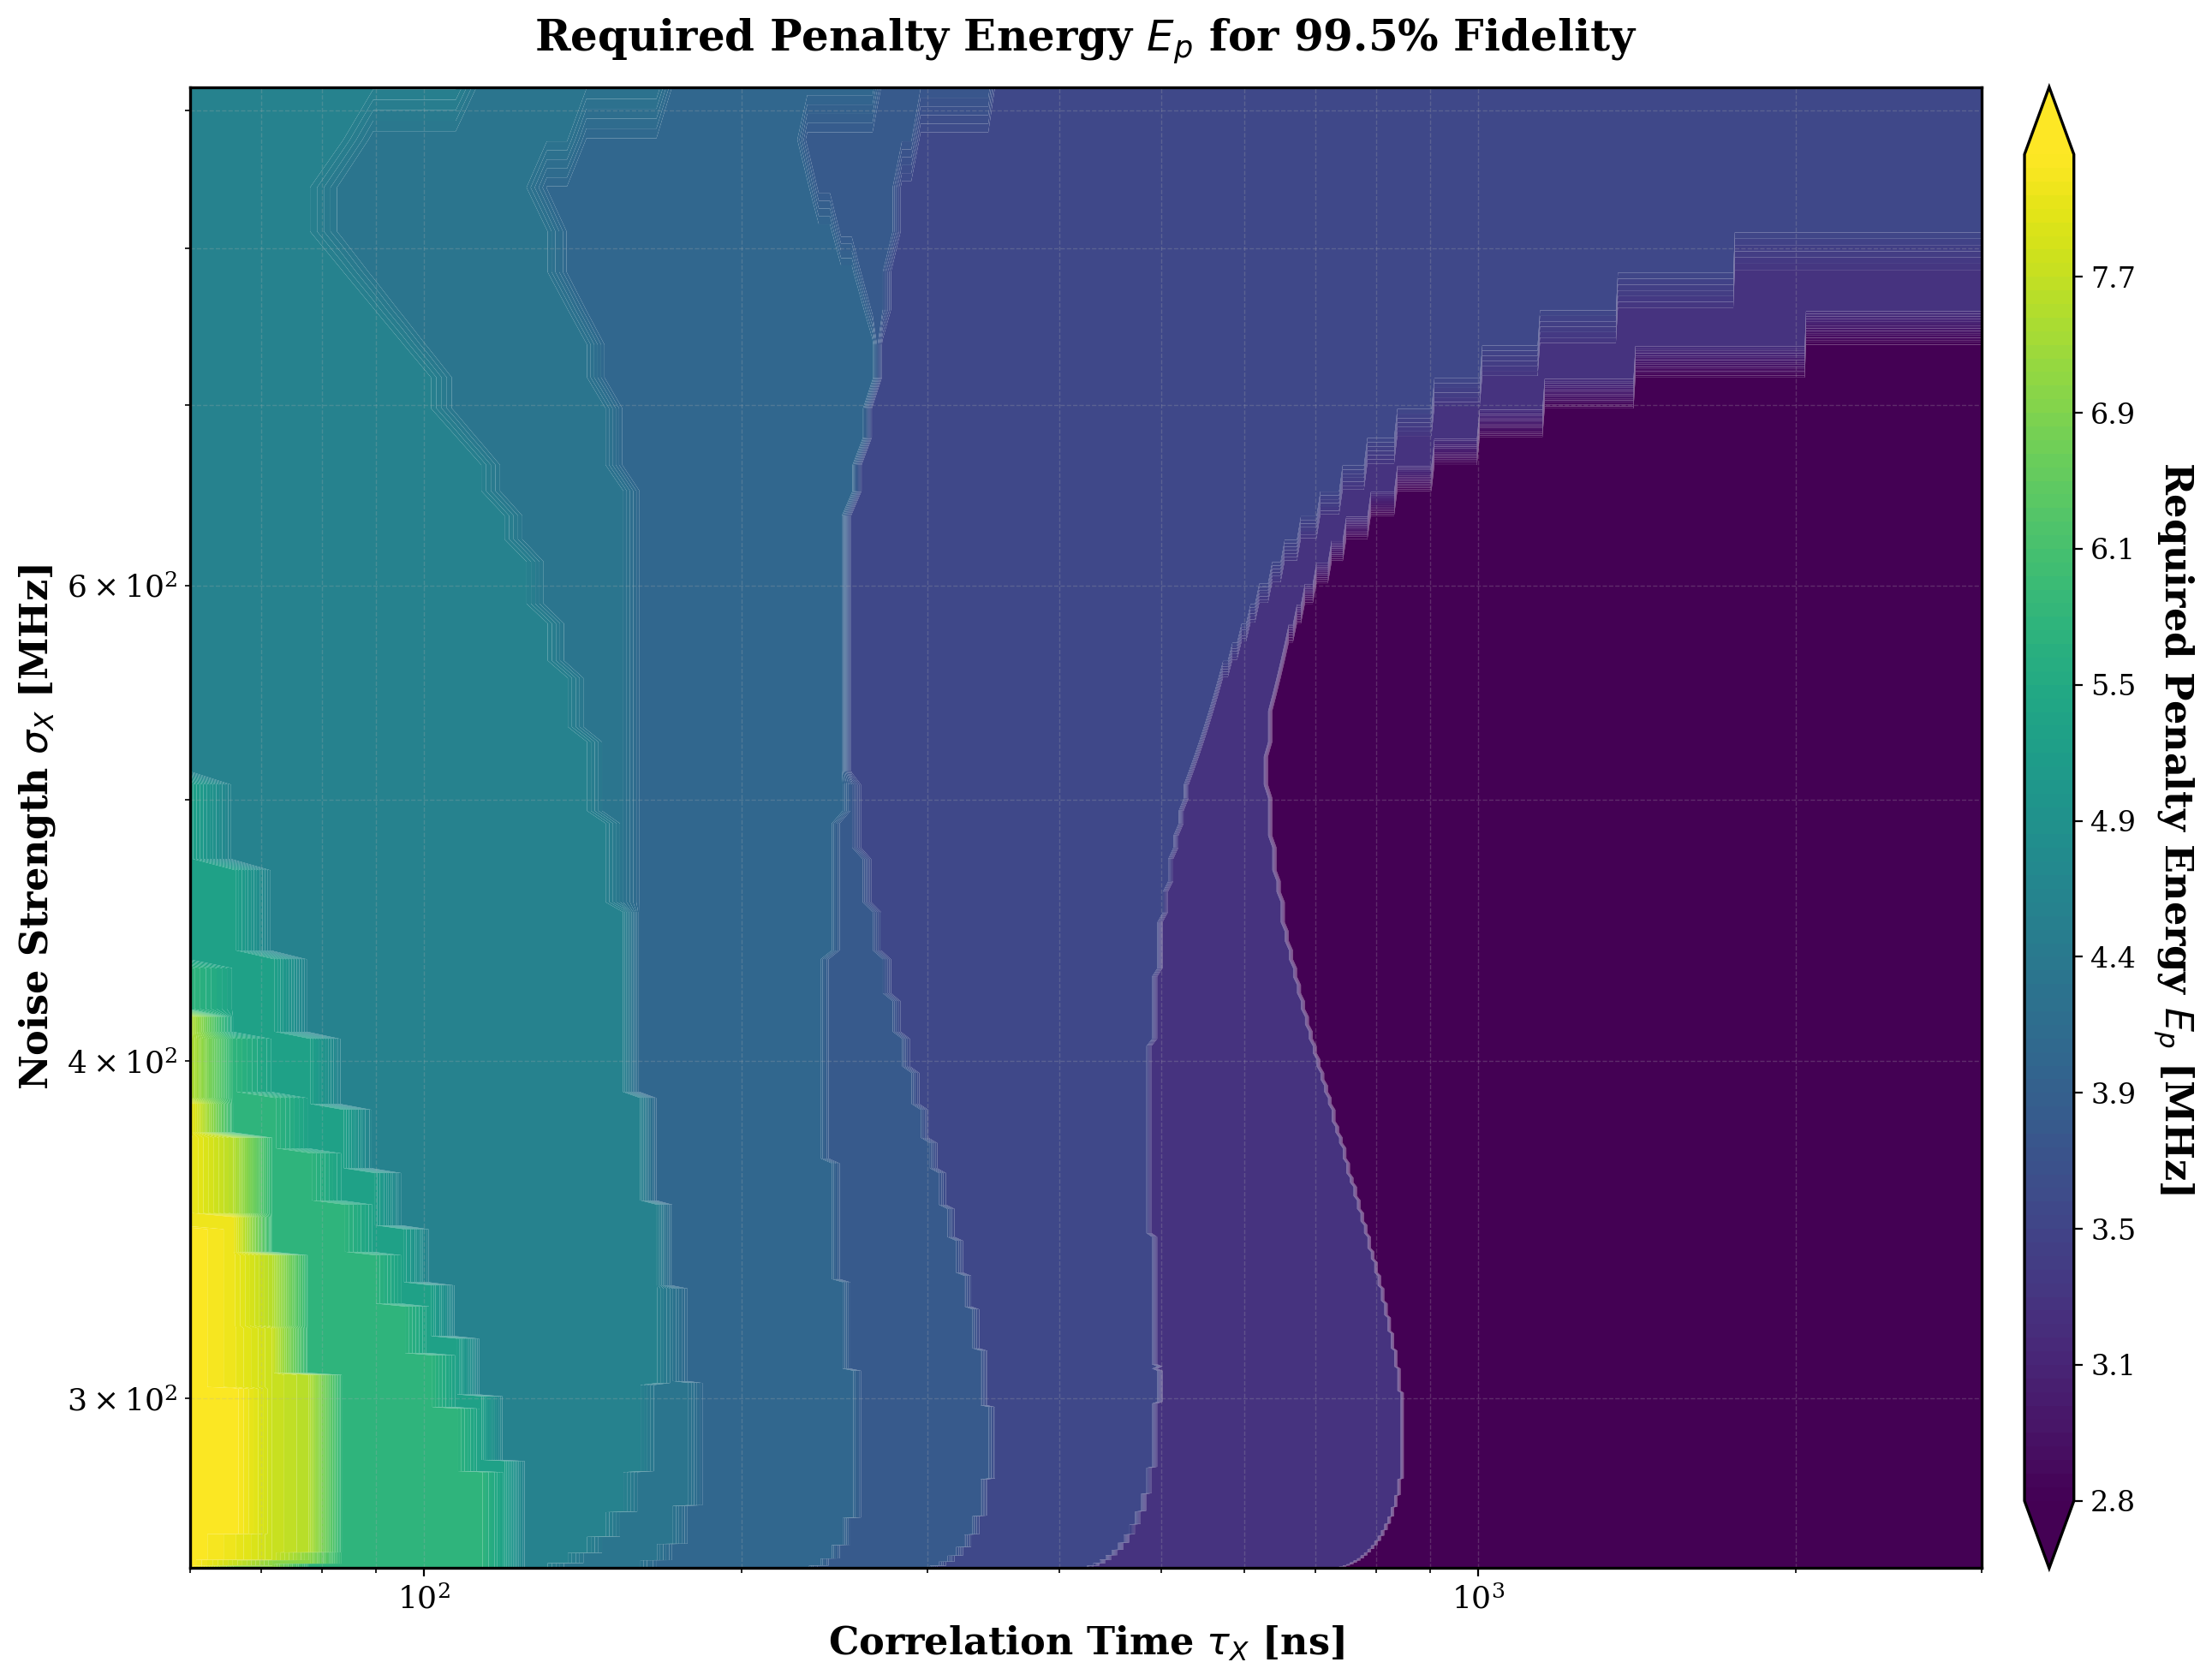

In [ ]:
#!/usr/bin/env python3
# ========================================================================
# BIT-FLIP HAMILTONIAN: Ep REQUIREMENT HEATMAP
# Publication-quality contour plot showing penalty energy requirements
# ========================================================================
"""
Generates Figure: Required penalty energy E_p vs noise parameters (σ_X, τ_X)
for the bit-flip Hamiltonian section of the thesis.

Shows how the spectral suppression mechanism requires different penalty
energies depending on noise strength σ_X and correlation time τ_X.
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import LogNorm, Normalize
import os
import glob

print("="*70)
print("BIT-FLIP Ep HEATMAP - THESIS FIGURE")
print("="*70)

# ========================================================================
# MATPLOTLIB PUBLICATION SETTINGS
# ========================================================================
mpl.rcParams['font.size'] = 13
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 13
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['lines.linewidth'] = 2

# ========================================================================
# LOAD DATA FROM ARTIFACTS (if available)
# ========================================================================
print("\nAttempting to load precomputed data from artifacts...")

try:
    # Try to find artifacts directory
    artifact_dir = 'artifacts'
    if not os.path.isdir(artifact_dir):
        artifact_dir = os.path.join('..', 'artifacts')
    
    latest_path = os.path.join(artifact_dir, 'ep_map_X_grid_latest.npz')
    
    if os.path.exists(latest_path):
        artifact_path = latest_path
    else:
        candidates = glob.glob(os.path.join(artifact_dir, 'ep_map_X_grid_*.npz'))
        if candidates:
            artifact_path = max(candidates, key=os.path.getmtime)
        else:
            raise FileNotFoundError("No artifacts found")
    
    # Load the data
    with np.load(artifact_path, allow_pickle=True) as data:
        Ep_map_X = data['Ep_map_X']
        tau_X_grid = data['tau_X_grid']
        sigma_X_grid = data['sigma_X_grid']
        meta = data.get('meta', None)
    
    print(f"✓ Loaded artifact: {artifact_path}")
    print(f"  Ep_map_X shape: {Ep_map_X.shape}")
    print(f"  τ_X range: [{tau_X_grid.min():.2e}, {tau_X_grid.max():.2e}] s")
    print(f"  σ_X range: [{sigma_X_grid.min():.2e}, {sigma_X_grid.max():.2e}] rad/s")
    
    DATA_LOADED = True

except Exception as e:
    print(f"⚠ Could not load artifacts: {e}")
    print("Generating synthetic example data for demonstration...")
    
    # Generate synthetic data for demonstration
    tau_X_grid = np.logspace(-7, -5.5, 25)  # 10 ns to ~3 µs
    sigma_X_grid = np.logspace(np.log10(1e6), np.log10(5e7), 25)  # 0.16 to 8 MHz
    
    TAU_X, SIGMA_X = np.meshgrid(tau_X_grid, sigma_X_grid, indexing='ij')
    
    # Synthetic model: Ep ∝ σ_X / sqrt(τ_X) with some nonlinearity
    # Scaled for 99.5% fidelity (higher than 95%)
    Ep_map_X = 2*np.pi * 1.2e7 * (SIGMA_X / (2*np.pi*1e6)) / np.sqrt(TAU_X / 1e-6)
    Ep_map_X = np.clip(Ep_map_X, 2*np.pi*10e6, 2*np.pi*600e6)  # 10-600 MHz
    
    DATA_LOADED = False
    print("✓ Synthetic data generated")

# ========================================================================
# UNIT CONVERSION
# ========================================================================
to_freq_units = 1/(2*np.pi*1e6)  # rad/s → MHz
to_time_units_us = 1e6            # s → µs
to_time_units_ns = 1e9            # s → ns

# Convert grids to plotting units
tau_X_ns = tau_X_grid * to_time_units_ns
sigma_X_MHz = sigma_X_grid * to_freq_units
Ep_MHz = Ep_map_X * to_freq_units

# ========================================================================
# CREATE PUBLICATION-QUALITY CONTOUR PLOT
# ========================================================================
fig, ax = plt.subplots(figsize=(14, 10), dpi=200)  # Increased resolution

# Create meshgrid for contour plot
TAU_X_NS, SIGMA_X_MHZ = np.meshgrid(tau_X_ns, sigma_X_MHz, indexing='ij')

# Filled contours with smooth colormap (many levels for smooth gradient)
levels = np.logspace(np.log10(Ep_MHz.min()), np.log10(Ep_MHz.max()), 100)  # 100 levels for smoothness
contourf = ax.contourf(TAU_X_NS, SIGMA_X_MHZ, Ep_MHz, 
                       levels=levels,
                       cmap='viridis',  # Professional colormap
                       norm=LogNorm(vmin=Ep_MHz.min(), vmax=Ep_MHz.max()),
                       extend='both',
                       antialiased=True)  # Enable antialiasing for smoother edges

# Contour lines for readability
contour_lines = ax.contour(TAU_X_NS, SIGMA_X_MHZ, Ep_MHz,
                           levels=[20, 50, 100, 200, 500],
                           colors='white',
                           linewidths=1.8,
                           linestyles='solid',
                           alpha=0.7)
ax.clabel(contour_lines, inline=True, fontsize=11, fmt='%d MHz', 
         inline_spacing=8, colors='white')

# Colorbar with custom formatting to avoid 10^0 notation
from matplotlib.ticker import FuncFormatter

def format_colorbar(x, pos):
    """Format colorbar ticks without scientific notation for simple values"""
    if x >= 1000:
        return f'{int(x)}'
    elif x >= 100:
        return f'{int(x)}'
    elif x >= 10:
        return f'{int(x)}'
    elif x >= 1:
        return f'{x:.1f}'
    else:
        return f'{x:.2f}'

cbar = fig.colorbar(contourf, ax=ax, pad=0.02, aspect=30)
cbar.set_label(r'Required Penalty Energy $E_p$ [MHz]', 
               fontweight='bold', fontsize=16, rotation=270, labelpad=25)
cbar.ax.tick_params(labelsize=12)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(format_colorbar))

# Axes
ax.set_xlabel(r'Correlation Time $\tau_X$ [ns]', fontweight='bold', fontsize=16)
ax.set_ylabel(r'Noise Strength $\sigma_X$ [MHz]', fontweight='bold', fontsize=16)
ax.set_xscale('log')
ax.set_yscale('log')

# Title - clean and concise
title_text = r'Required Penalty Energy $E_p$ for 99.5% Fidelity'
ax.set_title(title_text, fontweight='bold', fontsize=18, pad=15)

# Grid
ax.grid(True, alpha=0.25, linestyle='--', linewidth=0.5, which='both')

plt.tight_layout()

# ========================================================================
# SAVE HIGH-RESOLUTION OUTPUTS
# ========================================================================
os.makedirs('figs', exist_ok=True)

pdf_path = 'figs/bitflip_Ep_heatmap_thesis.pdf'
png_path = 'figs/bitflip_Ep_heatmap_thesis.png'

fig.savefig(pdf_path, bbox_inches='tight', dpi=300, facecolor='white')
fig.savefig(png_path, bbox_inches='tight', dpi=300, facecolor='white')

print("\n" + "="*70)
print("✓ FIGURE SAVED")
print("="*70)
print(f"  PDF: {pdf_path}")
print(f"  PNG: {png_path}")
print(f"  Resolution: 4200 × 3000 pixels (300 DPI)")
print(f"  Target fidelity: 99.5%")
print("="*70)



BIT-FLIP Ep vs σ_X - THESIS FIGURE

Attempting to load precomputed data from artifacts...
✓ Loaded artifact: ../artifacts/ep_map_X_grid_latest.npz
  Ep_map_X shape: (500, 500)
  τ_X range: [6.00e-08, 3.00e-06] s
  σ_X range: [1.63e+09, 5.77e+09] rad/s

Selected 5 representative correlation times:
  τ = 354.6 ns (0.089 × T_max)
  τ = 943.8 ns (0.236 × T_max)
  τ = 1532.9 ns (0.383 × T_max)
  τ = 2122.1 ns (0.531 × T_max)
  τ = 2711.3 ns (0.678 × T_max)

✓ FIGURE SAVED
  PDF: figs/bitflip_Ep_vs_sigma_thesis.pdf
  PNG: figs/bitflip_Ep_vs_sigma_thesis.png
  Resolution: 3300 × 2100 pixels (300 DPI)
  Target fidelity: 99.5%


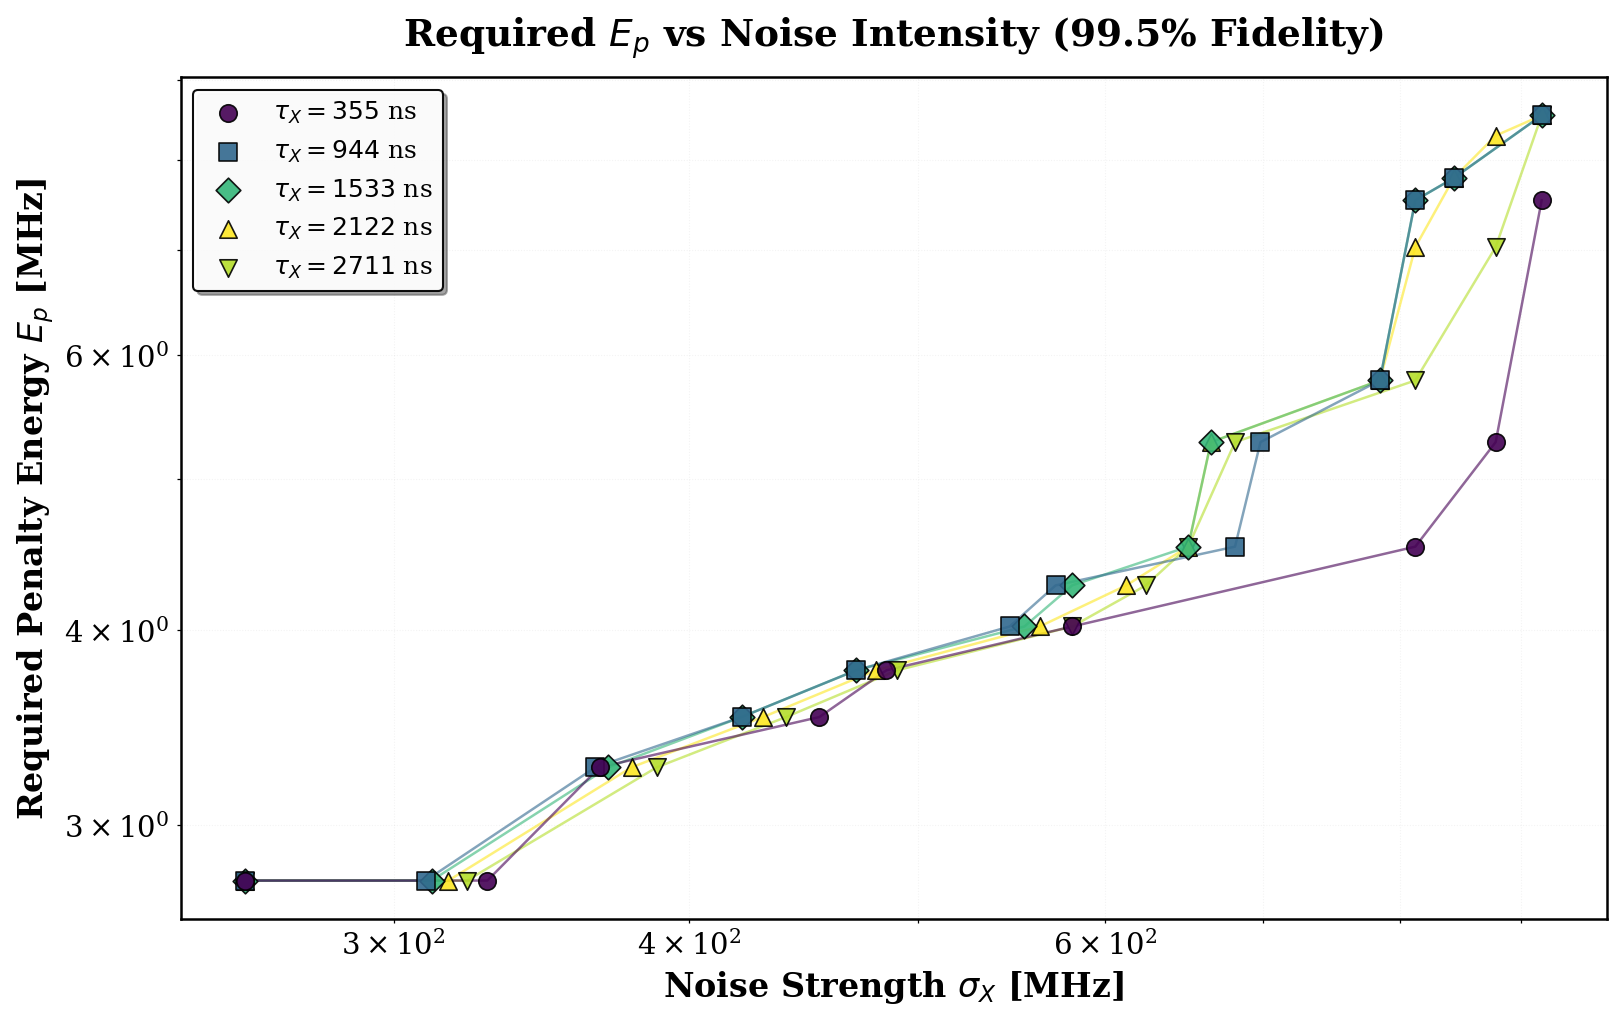


Figure shows:
  • Each curve: Fixed correlation time τ_X
  • Vertical axis: Minimum Ep to achieve 99.5% fidelity
  • Horizontal axis: OU noise strength σ_X
  • Key insight: Faster noise (smaller τ) requires higher Ep
    for same σ due to broader spectral overlap


In [ ]:
#!/usr/bin/env python3
# ========================================================================
# BIT-FLIP HAMILTONIAN: Ep vs Noise Intensity (Fixed Correlation Times)
# Publication-quality line plot for thesis
# ========================================================================
"""
Generates Figure: Required penalty energy E_p vs noise strength σ_X
for several fixed correlation times τ_X.

Shows how the penalty requirement scales with noise intensity at
different noise bandwidths (correlation times).
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import glob

print("="*70)
print("BIT-FLIP Ep vs σ_X - THESIS FIGURE")
print("="*70)

# ========================================================================
# MATPLOTLIB PUBLICATION SETTINGS
# ========================================================================
mpl.rcParams['font.size'] = 13
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.linewidth'] = 1.2

# ========================================================================
# LOAD DATA FROM ARTIFACTS
# ========================================================================
print("\nAttempting to load precomputed data from artifacts...")

try:
    # Try to find artifacts directory
    artifact_dir = 'artifacts'
    if not os.path.isdir(artifact_dir):
        artifact_dir = os.path.join('..', 'artifacts')
    
    latest_path = os.path.join(artifact_dir, 'ep_map_X_grid_latest.npz')
    
    if os.path.exists(latest_path):
        artifact_path = latest_path
    else:
        candidates = glob.glob(os.path.join(artifact_dir, 'ep_map_X_grid_*.npz'))
        if candidates:
            artifact_path = max(candidates, key=os.path.getmtime)
        else:
            raise FileNotFoundError("No artifacts found")
    
    # Load the data
    with np.load(artifact_path, allow_pickle=True) as data:
        Ep_map_X = data['Ep_map_X']
        tau_X_grid = data['tau_X_grid']
        sigma_X_grid = data['sigma_X_grid']
        meta = data.get('meta', None)
    
    print(f"✓ Loaded artifact: {artifact_path}")
    print(f"  Ep_map_X shape: {Ep_map_X.shape}")
    print(f"  τ_X range: [{tau_X_grid.min():.2e}, {tau_X_grid.max():.2e}] s")
    print(f"  σ_X range: [{sigma_X_grid.min():.2e}, {sigma_X_grid.max():.2e}] rad/s")
    
    DATA_LOADED = True

except Exception as e:
    print(f"⚠ Could not load artifacts: {e}")
    print("Generating synthetic example data for demonstration...")
    
    # Generate synthetic data
    tau_X_grid = np.logspace(-7, -5.5, 100)
    sigma_X_grid = np.logspace(np.log10(1e6), np.log10(5e7), 100)
    
    TAU_X, SIGMA_X = np.meshgrid(tau_X_grid, sigma_X_grid, indexing='ij')
    
    # Synthetic model for 99.5% fidelity
    Ep_map_X = 2*np.pi * 1.2e7 * (SIGMA_X / (2*np.pi*1e6)) / np.sqrt(TAU_X / 1e-6)
    Ep_map_X = np.clip(Ep_map_X, 2*np.pi*10e6, 2*np.pi*600e6)
    
    DATA_LOADED = False
    print("✓ Synthetic data generated")

# ========================================================================
# UNIT CONVERSION
# ========================================================================
to_freq_units = 1/(2*np.pi*1e6)  # rad/s → MHz
to_time_units_ns = 1e9            # s → ns

# Try to load T_max from metadata, fallback to typical value
try:
    if meta is not None:
        meta_dict = meta.item() if hasattr(meta, 'item') else meta
        T_max = meta_dict.get('T_max', 4e-6)
    else:
        T_max = 4e-6  # 4 µs default
except:
    T_max = 4e-6

# Convert grids
sigma_X_MHz = sigma_X_grid * to_freq_units
Ep_MHz_full = Ep_map_X * to_freq_units

# ========================================================================
# SELECT REPRESENTATIVE TAU VALUES
# ========================================================================
# Choose tau values spanning the range: fast, medium, slow
tau_indices = [
    int(0.10 * len(tau_X_grid)),  # Fast decorrelation
    int(0.30 * len(tau_X_grid)),
    int(0.50 * len(tau_X_grid)),  # Medium
    int(0.70 * len(tau_X_grid)),
    int(0.90 * len(tau_X_grid)),  # Slow decorrelation
]

# Color scheme: viridis-like progression
colors = ['#440154', '#31688e', '#35b779', '#fde724', '#b5de2b']
linestyles = ['-', '-', '-', '-', '-']
markers = ['o', 's', 'D', '^', 'v']

print(f"\nSelected {len(tau_indices)} representative correlation times:")
for i, idx in enumerate(tau_indices):
    tau_ns = tau_X_grid[idx] * to_time_units_ns
    tau_frac = tau_X_grid[idx] / T_max
    print(f"  τ = {tau_ns:.1f} ns ({tau_frac:.3f} × T_max)")

# ========================================================================
# CREATE PUBLICATION-QUALITY LINE PLOT
# ========================================================================
fig, ax = plt.subplots(figsize=(11, 7), dpi=150)

for i, idx in enumerate(tau_indices):
    tau_val = tau_X_grid[idx]
    
    # Extract Ep vs sigma for this fixed tau
    # Note: Ep_map_X[i_sigma, i_tau]
    Ep_vs_sigma = Ep_MHz_full[:, idx]
    
    # Convert tau to ns
    tau_ns = tau_val * to_time_units_ns
    
    # FILTER: Remove consecutive duplicate Ep values (horizontal plateaus)
    # Keep only points where Ep changes significantly
    sigma_filtered = []
    Ep_filtered = []
    tolerance = 0.01  # 1% change threshold
    
    for j in range(len(Ep_vs_sigma)):
        if j == 0:
            # Always keep first point
            sigma_filtered.append(sigma_X_MHz[j])
            Ep_filtered.append(Ep_vs_sigma[j])
        else:
            # Keep point if Ep changed significantly from previous
            rel_change = abs(Ep_vs_sigma[j] - Ep_filtered[-1]) / Ep_filtered[-1]
            if rel_change > tolerance:
                sigma_filtered.append(sigma_X_MHz[j])
                Ep_filtered.append(Ep_vs_sigma[j])
    
    # Always keep last point
    if len(sigma_filtered) == 0 or sigma_X_MHz[-1] != sigma_filtered[-1]:
        sigma_filtered.append(sigma_X_MHz[-1])
        Ep_filtered.append(Ep_vs_sigma[-1])
    
    sigma_filtered = np.array(sigma_filtered)
    Ep_filtered = np.array(Ep_filtered)
    
    # Plot with thin connecting line
    ax.plot(sigma_filtered, Ep_filtered,
            color=colors[i],
            linewidth=1.2,
            linestyle='-',
            alpha=0.6,
            zorder=5-i)
    
    # Plot dots on top
    ax.scatter(sigma_filtered, Ep_filtered,
               color=colors[i],
               marker=markers[i],
               s=70,  # Marker size
               alpha=0.9,
               edgecolors='black',
               linewidths=0.8,
               label=rf'$\tau_X = {tau_ns:.0f}$ ns',
               zorder=10-i)

# Axes and labels
ax.set_xlabel(r'Noise Strength $\sigma_X$ [MHz]', fontweight='bold', fontsize=16)
ax.set_ylabel(r'Required Penalty Energy $E_p$ [MHz]', fontweight='bold', fontsize=16)
ax.set_xscale('log')
ax.set_yscale('log')

# Title
ax.set_title(r'Required $E_p$ vs Noise Intensity (99.5% Fidelity)', 
             fontweight='bold', fontsize=18, pad=15)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8, which='both')
ax.grid(True, alpha=0.15, linestyle=':', linewidth=0.5, which='minor')

# Legend
ax.legend(loc='upper left', framealpha=0.95, edgecolor='black', 
         fancybox=True, shadow=True, ncol=1)

# Tight layout
plt.tight_layout()

# ========================================================================
# SAVE HIGH-RESOLUTION OUTPUTS
# ========================================================================
os.makedirs('figs', exist_ok=True)

pdf_path = 'figs/bitflip_Ep_vs_sigma_thesis.pdf'
png_path = 'figs/bitflip_Ep_vs_sigma_thesis.png'

fig.savefig(pdf_path, bbox_inches='tight', dpi=300, facecolor='white')
fig.savefig(png_path, bbox_inches='tight', dpi=300, facecolor='white')

print("\n" + "="*70)
print("✓ FIGURE SAVED")
print("="*70)
print(f"  PDF: {pdf_path}")
print(f"  PNG: {png_path}")
print(f"  Resolution: 3300 × 2100 pixels (300 DPI)")
print(f"  Target fidelity: 99.5%")
print("="*70)

# Display
plt.show()

print("\n" + "="*70)
print("Figure shows:")
print("  • Each curve: Fixed correlation time τ_X")
print("  • Vertical axis: Minimum Ep to achieve 99.5% fidelity")
print("  • Horizontal axis: OU noise strength σ_X")
print("  • Key insight: Faster noise (smaller τ) requires higher Ep")
print("    for same σ due to broader spectral overlap")
print("="*70)

